# QC pVCF files UKBB

## Aim

To do QC on the UKBB pVCF data and return plink files for downstream GWAS analysis


## Input

* pVCF file

## Ouput

* bed, bim and fam files per chromosome

## Understanding pre-QC done in the UKBB



## Software

In this case we will use [bcftools](http://www.htslib.org/download/)

## Conventions
```
INFO/AC        Number:A  Type:Integer  ..  Allele count in genotypes
INFO/AC_Hom    Number:A  Type:Integer  ..  Allele counts in homozygous genotypes
INFO/AC_Het    Number:A  Type:Integer  ..  Allele counts in heterozygous genotypes
INFO/AC_Hemi   Number:A  Type:Integer  ..  Allele counts in hemizygous genotypes
INFO/AF        Number:A  Type:Float    ..  Allele frequency
INFO/AN        Number:1  Type:Integer  ..  Total number of alleles in called genotypes
INFO/ExcHet    Number:A  Type:Float    ..  Test excess heterozygosity; 1=good, 0=bad
INFO/END       Number:1  Type:Integer  ..  End position of the variant
INFO/F_MISSING Number:1  Type:Float    ..  Fraction of missing genotypes (all samples, experimental)
INFO/HWE       Number:A  Type:Float    ..  HWE test (PMID:15789306); 1=good, 0=bad
INFO/MAF       Number:A  Type:Float    ..  Minor Allele frequency
INFO/NS        Number:1  Type:Integer  ..  Number of samples with data
INFO/TYPE      Number:.  Type:String   ..  The record type (REF,SNP,MNP,INDEL,etc)
FORMAT/VAF     Number:A  Type:Float    ..  The fraction of reads with the alternate allele, requires FORMAT/AD
FORMAT/VAF1    Number:1  Type:Float    ..  The same as FORMAT/VAF but for all alternate alleles cumulatively
TAG=func(TAG)  Number:1  Type:Integer  ..  Experimental support for user-defined expressions such as "DP=sum(DP)". This is currently very basic, to be extended.
```

In [1]:
# Plugin commands

## Print a detailed list of available tags
bcftools +fill-tags -- -l

INFO/AC        Number:A  Type:Integer  ..  Allele count in genotypes
INFO/AC_Hom    Number:A  Type:Integer  ..  Allele counts in homozygous genotypes
INFO/AC_Het    Number:A  Type:Integer  ..  Allele counts in heterozygous genotypes
INFO/AC_Hemi   Number:A  Type:Integer  ..  Allele counts in hemizygous genotypes
INFO/AF        Number:A  Type:Float    ..  Allele frequency
INFO/AN        Number:1  Type:Integer  ..  Total number of alleles in called genotypes
INFO/ExcHet    Number:A  Type:Float    ..  Test excess heterozygosity; 1=good, 0=bad
INFO/END       Number:1  Type:Integer  ..  End position of the variant
INFO/F_MISSING Number:1  Type:Float    ..  Fraction of missing genotypes (all samples, experimental)
INFO/HWE       Number:A  Type:Float    ..  HWE test (PMID:15789306); 1=good, 0=bad
INFO/MAF       Number:A  Type:Float    ..  Minor Allele frequency
INFO/NS        Number:1  Type:Integer  ..  Number of samples with data
INFO/TYPE      Number:.  Type:String   ..  The record type (RE

In [3]:
# Fill all available tags -Oz for vcf.gz or -Ob for bcf

bcftools +fill-tags $vcf_file -Oz -o $vcf_out -- -t all

In [ ]:
# Calculate total read depth (INFO/DP) from per-sample depths (FORMAT/DP)

bcftools +fill-tags $vcf_file -Oz -o $vcf_out -- -t 'DP=sum(DP)'

## Produce stats of the VCF files

In [1]:
bcf=~/software/bin/./bcftools
plot=~/software/bin/./plot-vcfstats
vcf_file=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c1_b0_v1.vcf.gz
vcf_out=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c1_b0_v1.test.vcf.gz

## Generate MWE data for real UKBB file

In [ ]:
bcftools view /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c1_b0_v1.vcf.gz| vcfrandomsample -r 0.012 > /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr1_mwe.subset.vcf.gz

### Number of variants per file

In [3]:
$bcf view -H $vcf_file | wc -l

16310



# 1. Preparation

### Index vcf

In [28]:
bcftools view $vcf_file && bcftools index $vcf_file -t # data.vcf.gz.tbi

Restarting kernel "Bash"

About:   VCF/BCF conversion, view, subset and filter VCF/BCF files.
Usage:   bcftools view [options] <in.vcf.gz> [region1 [...]]

Output options:
    -G,   --drop-genotypes              drop individual genotype information (after subsetting if -s option set)
    -h/H, --header-only/--no-header     print the header only/suppress the header in VCF output
    -l,   --compression-level [0-9]     compression level: 0 uncompressed, 1 best speed, 9 best compression [-1]
          --no-version                  do not append version and command line to the header
    -o,   --output <file>               output file name [stdout]
    -O,   --output-type <b|u|z|v>       b: compressed BCF, u: uncompressed BCF, z: compressed VCF, v: uncompressed VCF [v]
    -r, --regions <region>              restrict to comma-separated list of regions
    -R, --regions-file <file>           restrict to regions listed in a file
    -t, --targets [^]<region>           similar to -r but strea

In [ ]:
bcftools index $vcf_file -t

In [ ]:
bcftools +fill-tags -- -l

### Check samples

In [26]:
bcftools query -l $vcf_file | head

1434748
5523981
5023838
4023729
4442146
5654789
4515669
1129683
5327043
4744741



### Check variants: obtain number of variants

In [ ]:
#Obtain number of variants needs to be indexed first
bcftools index -n $vcf_file 

### Inspection of Quality Measurements


In [3]:
$bcf stats -s - $vcf_file >  ~/output/vcf_stats/ukbb_chr1_b1.vchk

In [22]:
plot-vcfstats -p ~/output/vcf_stats/ ~/output/vcf_stats/ukbb_chr1_b1.vchk

Parsing bcftools stats output: /home/dmc2245/output/vcf_stats/ukbb_chr1_b1.vchk
Plotting graphs: python3 plot.py
Creating PDF: tectonic summary.tex >plot-vcfstats.log 2>&1
The command exited with non-zero status, please consult the output of tectonic: /home/dmc2245/output/vcf_stats/plot-vcfstats.log

 at /home/dmc2245/software/bin/plot-vcfstats line 111.
	main::error("The command exited with non-zero status, please consult the o"...) called at /home/dmc2245/software/bin/plot-vcfstats line 2123
	main::create_pdf(HASH(0x564585baf348)) called at /home/dmc2245/software/bin/plot-vcfstats line 72



> /home/dmc2245/output/vcf_stats/depth.0.png (25.4 KiB):

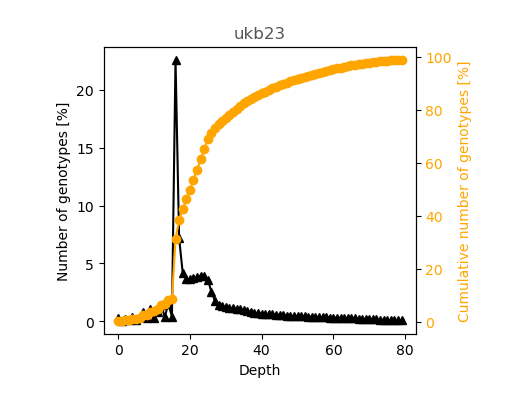

>>> ~/output/vcf_stats/depth.0.png:

bash: /home/dmc2245/output/vcf_stats/depth.0.png: Permission denied



In [10]:
%preview -s png  ~/output/vcf_stats/depth.0.png

> /home/dmc2245/output/vcf_stats/dp_by_sample.0.png (21.0 KiB):

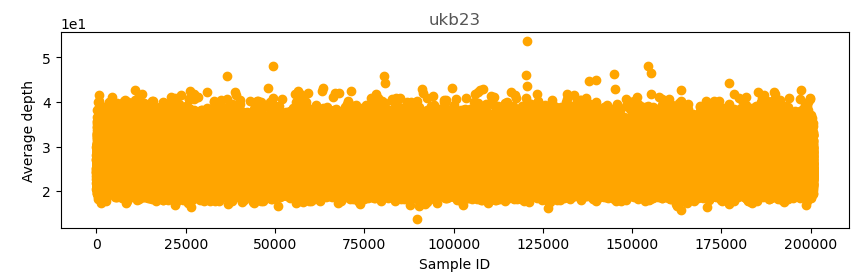

>>> ~/output/vcf_stats/dp_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/dp_by_sample.0.png: Permission denied



In [11]:
%preview -s png  ~/output/vcf_stats/dp_by_sample.0.png

> /home/dmc2245/output/vcf_stats/hets_by_sample.0.png (28.0 KiB):

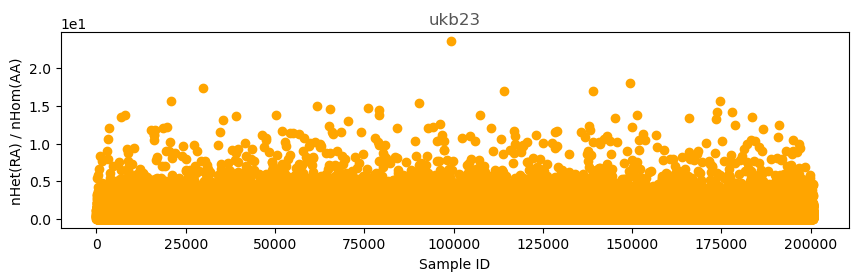

>>> ~/output/vcf_stats/hets_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/hets_by_sample.0.png: Permission denied



In [12]:
%preview -s png  ~/output/vcf_stats/hets_by_sample.0.png

> /home/dmc2245/output/vcf_stats/hwe.0.png (32.5 KiB):

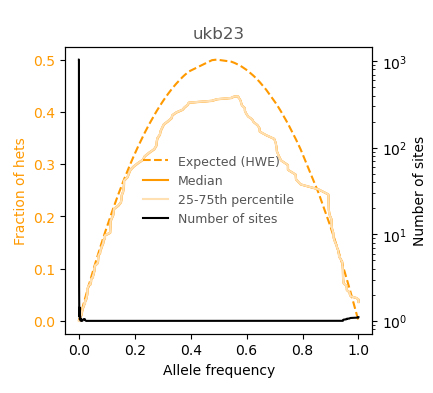

>>> ~/output/vcf_stats/hwe.0.png:

bash: /home/dmc2245/output/vcf_stats/hwe.0.png: Permission denied



In [13]:
%preview -s png  ~/output/vcf_stats/hwe.0.png

> /home/dmc2245/output/vcf_stats/indel_vaf.0.png (30.0 KiB):

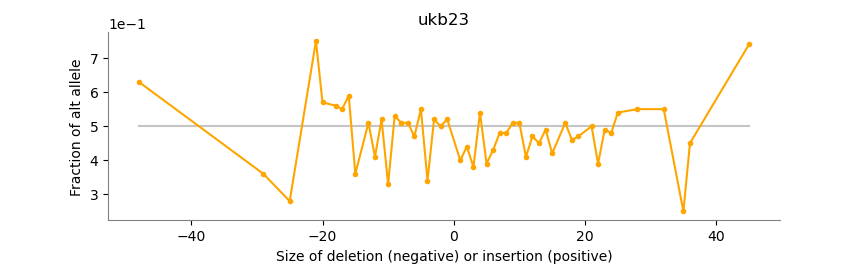

>>> ~/output/vcf_stats/indel_vaf.0.png:

bash: /home/dmc2245/output/vcf_stats/indel_vaf.0.png: Permission denied



In [14]:
%preview -s png  ~/output/vcf_stats/indel_vaf.0.png

> /home/dmc2245/output/vcf_stats/indels.0.png (11.8 KiB):

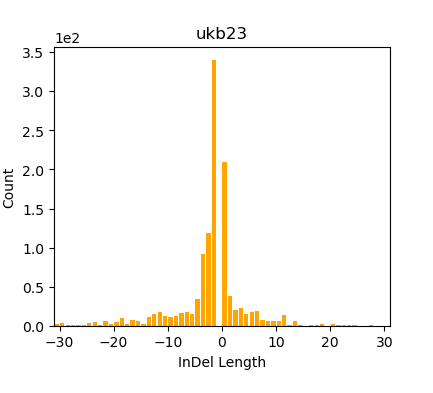

>>> ~/output/vcf_stats/indels.0.png:

bash: /home/dmc2245/output/vcf_stats/indels.0.png: Permission denied



In [15]:
%preview -s png  ~/output/vcf_stats/indels.0.png

> /home/dmc2245/output/vcf_stats/indels_by_sample.0.png (30.0 KiB):

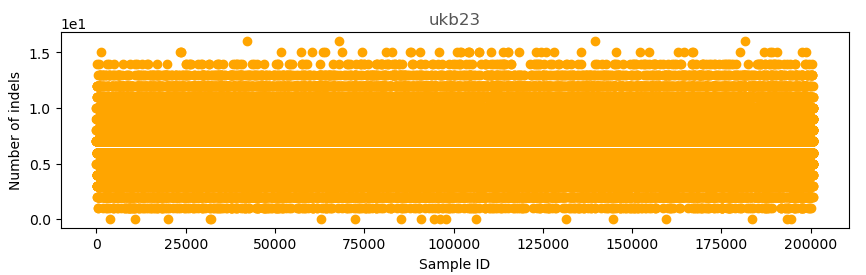

>>> ~/output/vcf_stats/indels_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/indels_by_sample.0.png: Permission denied



In [16]:
%preview -s png  ~/output/vcf_stats/indels_by_sample.0.png

> /home/dmc2245/output/vcf_stats/singletons_by_sample.0.png (17.9 KiB):

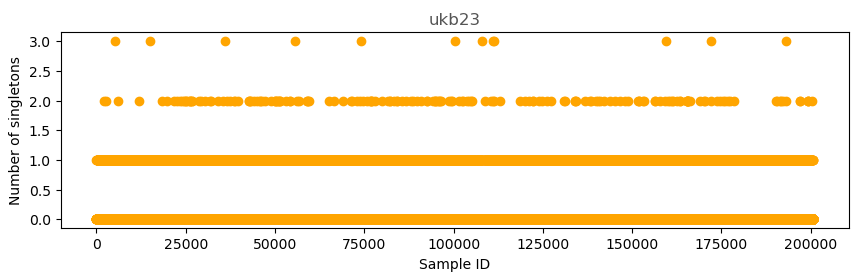

>>> ~/output/vcf_stats/singletons_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/singletons_by_sample.0.png: Permission denied



In [17]:
%preview -s png  ~/output/vcf_stats/singletons_by_sample.0.png

> /home/dmc2245/output/vcf_stats/snps_by_sample.0.png (25.9 KiB):

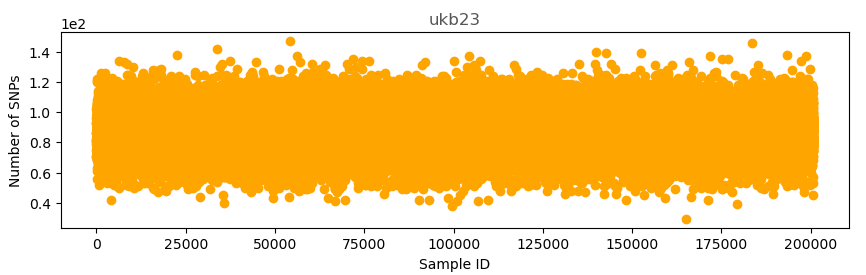

>>> ~/output/vcf_stats/snps_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/snps_by_sample.0.png: Permission denied



In [18]:
%preview -s png  ~/output/vcf_stats/snps_by_sample.0.png

> /home/dmc2245/output/vcf_stats/substitutions.0.png (12.3 KiB):

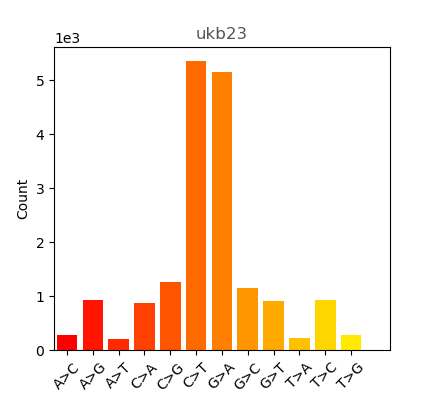

>>> ~/output/vcf_stats/substitutions.0.png:

bash: /home/dmc2245/output/vcf_stats/substitutions.0.png: Permission denied



In [19]:
%preview -s png  ~/output/vcf_stats/substitutions.0.png

> /home/dmc2245/output/vcf_stats/tstv_by_qual.0.png (18.4 KiB):

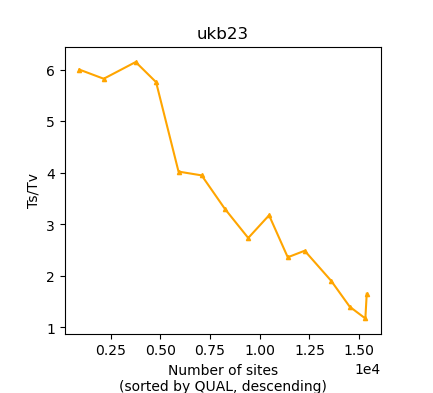

>>> ~/output/vcf_stats/tstv_by_qual.0.png:

bash: /home/dmc2245/output/vcf_stats/tstv_by_qual.0.png: Permission denied



In [20]:
%preview -s png  ~/output/vcf_stats/tstv_by_qual.0.png

> /home/dmc2245/output/vcf_stats/tstv_by_sample.0.png (25.9 KiB):

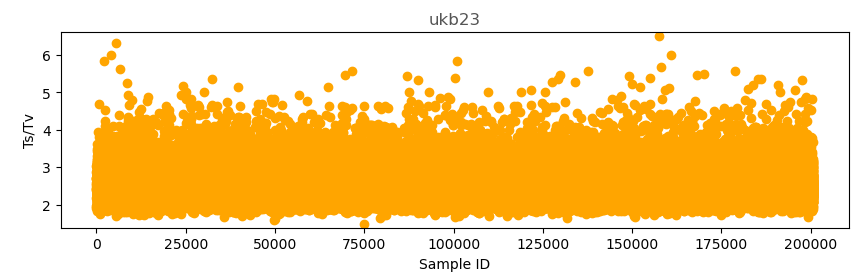

>>> ~/output/vcf_stats/tstv_by_sample.0.png:

bash: /home/dmc2245/output/vcf_stats/tstv_by_sample.0.png: Permission denied



In [21]:
%preview -s png  ~/output/vcf_stats/tstv_by_sample.0.png

# 2. Apply hard quality filters

In [2]:
#Take a look at the FORMAT/GQ, FORMAT/DP and AB measures

$bcf query $vcf_file -f '[%GQ]\t[%DP]\n' > ~/output/vcf_stats/chr1.GQ.DP.txt

In [1]:
$bcf stats --af-bins 0.1,0.5,1 -d 0,500,1 $vcf_file >  ~/output/vcf_stats/ukbb_chr1_b1.vchk

In [ ]:
$bcf AVG(GQ)>50 

In [ ]:
$bcf query -i 'GT = "alt" & GT = "hom"' -f "%CHROM\t%POS\n[\t%SAMPLE\t%GT\t%GQ\n]" $vcf_file

In [ ]:
$bcf query -f "%CHROM\t%POS\t%ID\t%INFO/AF\t%QUAL\t%INFO/BaseQRankSum" $vcf_file

In [ ]:
$bcf query -e'FILTER="."' -f'%CHROM %POS %FILTER\n' $vcf_file | head -2

In [ ]:
$bcf view -i 'GT="het" && (AB >0.20)' $vcf_file | head -2

In [ ]:
$bcf query -i'FMT/DP>10 & FMT/GQ>20' -f'%CHROM\tPOS\t%QUAL\t[%SAMPLE:DP=%DP GQ=%GQ]\n' $vcf_file | head -2

In [ ]:
$bcf query -i 'TYPE="snp" && MIN(DP)>5 && QUAL>10' -f'%CHROM\tPOS\t%QUAL\t[%SAMPLE:DP=%DP GQ=%GQ]\n' $vcf_file | head -2

### Plot VCF stats

In [ ]:
~/software/bin/./plot-vcfstats --merge chr{1..22} > ~/output/vcf_stats/merged_stats.vchk

In [ ]:
~/software/bin/./plot-vcfstats \
    --prefix ~/output/vcf_stats/merged_plots \
    --main-title 'Summary statistics plots for UKBB pVCF'\
    ~/output/vcf_stats/merged_stats.vchk

### Filter VCF files

1. Genotype depth filters: SNPs DP>=7 and Indels DP>=10 for indels
    > Then only SNV variant sites that met at least one of the following two criteria were [retained](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjPw5r_s5fvAhUVUzUKHe7GD-kQFjAEegQIDRAD&url=https%3A%2F%2Fwww.biorxiv.org%2Fcontent%2Fbiorxiv%2Fearly%2F2019%2F03%2F09%2F572347%2FDC2%2Fembed%2Fmedia-2.pdf%3Fdownload%3Dtrue&usg=AOvVaw06fvt4jBTPq5VfepojT1mZ) according to filtering made on the ~50K exomes by the UKBB
    
    > 1) at least one heterozygous variant genotype with allele balance ratio greater than or equal to 15% (AB >= 0.15) 
    
    > 2) at least one homozygous variant genotype
    
2. At least one variant genotype passing the Allele Balance filter: heterozygous SNV AB>=0.15, heterozygous indel>=0.20
3. Genotype quality GQ>=20

### Create an even smaller MWE with few variants and samples

This is done to make sure the code for filtering is working


In [1]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools

In [32]:
bcftools view -s 1434748,5523981 chr3_mwe.subset.leftnorm.vcf.gz -Oz -o chr3_mwe.subset_2samples.leftnorm.vcf.gz

In [33]:
#Get the header only
bcftools view -h chr3_mwe.subset_2samples.leftnorm.vcf.gz > header_vcf.txt

In [34]:
#Get the genotypes only
bcftools view -H chr3_mwe.subset_2samples.leftnorm.vcf.gz > samples_vcf.txt

In [9]:
bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP\t]\n' chr3_mwe.subset_2samples.leftnorm.vcf.gz | grep -v "^#"

chr3	43332376	TAATATGTC	T	GT=0/1:AD=7,10:DP=17	GT=0/0:AD=15,0:DP=15	
chr3	43332380	A	G	GT=0/1:AD=3,3:DP=6	GT=0/0:AD=15,0:DP=15	
chr3	43332382	G	A	GT=0/1:AD=35,5:DP=40	GT=0/1:AD=29,1:DP=30	
chr3	43332384	C	G	GT=1/1:AD=7,7:DP=14	GT=0/0:AD=15,0:DP=15	
chr3	43340428	G	A	GT=0/0:AD=21,0:DP=21	GT=0/0:AD=16,0:DP=16	
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG	GT=0/1:AD=7,2:DP=9	GT=0/0:AD=19,0:DP=19	
chr3	43372724	C	T	GT=0/0:AD=6,0:DP=6	GT=0/0:AD=16,0:DP=16	
chr3	43549662	T	C	GT=0/0:AD=14,0:DP=14	GT=0/0:AD=16,0:DP=16	
chr3	43576874	T	C	GT=0/0:AD=21,0:DP=21	GT=0/0:AD=18,0:DP=18	


In [73]:
# Changed manually some genotypes and removed variants using vim
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' chr3_mwe.subset_2samples.leftnorm.vcf.gz -Oz -o chr3_mwe.subset_2samples.filter_1.vcf.gz

In [8]:
bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP\t]\n' chr3_mwe.subset_2samples.filter_1.vcf.gz | grep -v "^#"

chr3	43332376	TAATATGTC	T	GT=0/1:AD=7,10:DP=17	GT=0/0:AD=15,0:DP=15	
chr3	43332380	A	G	GT=./.:AD=3,3:DP=6	GT=0/0:AD=15,0:DP=15	
chr3	43332382	G	A	GT=0/1:AD=35,5:DP=40	GT=0/1:AD=29,1:DP=30	
chr3	43332384	C	G	GT=1/1:AD=7,7:DP=14	GT=0/0:AD=15,0:DP=15	
chr3	43340428	G	A	GT=0/0:AD=21,0:DP=21	GT=0/0:AD=16,0:DP=16	
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG	GT=./.:AD=7,2:DP=9	GT=0/0:AD=19,0:DP=19	
chr3	43372724	C	T	GT=./.:AD=6,0:DP=6	GT=0/0:AD=16,0:DP=16	
chr3	43549662	T	C	GT=0/0:AD=14,0:DP=14	GT=0/0:AD=16,0:DP=16	
chr3	43576874	T	C	GT=0/0:AD=21,0:DP=21	GT=0/0:AD=18,0:DP=18	


In [74]:
# Exclude monomorphic variants
bcftools view -c 1 chr3_mwe.subset_2samples.filter_1.vcf.gz -Oz -o chr3_mwe.subset_2samples.filter_2.vcf.gz

In [7]:
bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP\t]\n' chr3_mwe.subset_2samples.filter_2.vcf.gz | grep -v "^#"

chr3	43332376	TAATATGTC	T	GT=0/1:AD=7,10:DP=17	GT=0/0:AD=15,0:DP=15	
chr3	43332382	G	A	GT=0/1:AD=35,5:DP=40	GT=0/1:AD=29,1:DP=30	
chr3	43332384	C	G	GT=1/1:AD=7,7:DP=14	GT=0/0:AD=15,0:DP=15	


In [76]:
# Remove using allelic imbalance
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)' chr3_mwe.subset_2samples.filter_2.vcf.gz -Oz -o chr3_mwe.subset_2samples.filter_3.vcf.gz

In [6]:
bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP\t]\n' chr3_mwe.subset_2samples.filter_3.vcf.gz | grep -v "^#"

chr3	43332376	TAATATGTC	T	GT=0/1:AD=7,10:DP=17	GT=0/0:AD=15,0:DP=15	
chr3	43332384	C	G	GT=1/1:AD=7,7:DP=14	GT=0/0:AD=15,0:DP=15	


In [2]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' chr3_mwe.subset_2samples.leftnorm.vcf.gz |
bcftools view -c1 | 
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)' -Oz -o chr3_mwe.subset_2samples.filter_codecomplete.vcf.gz

## Code complete and remove info from VCF file

In [3]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools

In [2]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' chr3_mwe.subset_2samples.leftnorm.vcf.gz |
bcftools view -c1 | 
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)' | bcftools annotate -x INFO,^FORMAT/GT -Oz -o chr3_mwe.subset_2samples.filter_codecomplete_removeinfo.vcf.gz

In [3]:
bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP\t]\n' chr3_mwe.subset_2samples.filter_codecomplete.vcf.gz| grep -v "^#"

chr3	43332376	TAATATGTC	T	GT=0/1:AD=7,10:DP=17	GT=0/0:AD=15,0:DP=15	
chr3	43332384	C	G	GT=1/1:AD=7,7:DP=14	GT=0/0:AD=15,0:DP=15	


## Use chr3_subset to integrate new filtering strategy

In [2]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools

In [8]:
zcat chr3_mwe.subset_10samples.vcf.gz | grep -v "^#" | wc -l

193


In [ ]:
bcftools norm -m-any chr3_mwe.subset_10samples.vcf.gz| \
    bcftools norm --check-ref w -f /home/dmc2245/software/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa -Oz | \
    bcftools annotate -Oz -x ID -I +'%CHROM:%POS:%REF:%ALT'  > chr3_mwe.subset.leftnorm.pipeline.vcf.gz

In [9]:
zcat chr3_mwe.subset.leftnorm.pipeline.vcf.gz | grep -v "^#" | wc -l

215


In [18]:
bcftools query -i 'FILTER="."' -f'%CHROM %POS %FILTER\n' chr3_mwe.subset.leftnorm.pipeline.vcf.gz | wc -l

215


In [19]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' chr3_mwe.subset.leftnorm.pipeline.vcf.gz -Oz -o chr3_mwe.subset.leftnorm.filtered1.vcf.gz

In [20]:
zcat chr3_mwe.subset.leftnorm.filtered1.vcf.gz | grep -v "^#" | wc -l

215


In [25]:
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)'  chr3_mwe.subset.leftnorm.filtered1.vcf.gz -Oz -o chr3_mwe.subset.leftnorm.filtered2.vcf.gz

In [26]:
zcat chr3_mwe.subset.leftnorm.filtered2.vcf.gz | grep -v "^#" | wc -l

215


In [13]:
bcftools query -e 'GT ="0/0"' -f'%CHROM %POS [ %GT]\n' chr3_mwe.subset.leftnorm.filtered2.vcf.gz

chr3 43332376  ./. ./.
chr3 43332380  ./. ./.
chr3 43332382  ./. ./.
chr3 43332384  ./. ./.
chr3 43372724  ./. ./. ./.
chr3 43576874  0/1
chr3 43598764  ./. ./. ./. ./. ./. ./.
chr3 43717573  ./. ./. ./.
chr3 44254912  ./.
chr3 44262549  ./. ./. ./. ./.
chr3 44281893  ./.
chr3 44287934  ./. ./. ./. ./. ./. ./. ./. ./. ./.
chr3 44290944  ./.
chr3 44306284  ./. ./.
chr3 44328526  ./. ./. ./. ./. ./. ./. ./. ./. ./.
chr3 44393070  ./. ./. ./.
chr3 44396308  ./.
chr3 44407774  ./.
chr3 44451575  ./.
chr3 44503077  ./. ./. ./. ./. ./. ./.
chr3 44567889  ./. ./. ./. ./. ./. ./. ./. ./.
chr3 44780821  ./. ./. ./.
chr3 44780823  ./. ./. ./.
chr3 44804985  ./.
chr3 44804985  ./.
chr3 44804985  ./.
chr3 44804985  ./.
chr3 44827360  ./. ./. ./. ./. ./. ./.
chr3 44830013  0/1 0/1 0/1 0/1
chr3 44840982  ./.
chr3 44848100  ./. ./. ./.
chr3 44893755  ./.
chr3 44902029  ./.
chr3 44997344  ./. ./.
chr3 45011185  ./. ./. ./. ./.
chr3 45394357  ./. ./. ./. 0/1 ./. ./. ./.
chr3 45419609  ./. ./.
chr3 4545

In [16]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n'  chr3_mwe.subset.leftnorm.filtered2.vcf.gz

chr3	43332376	TAATATGTC	T	AC=0	AN=16
chr3	43332380	A	G	AC=0	AN=16
chr3	43332382	G	A	AC=0	AN=16
chr3	43332384	C	G	AC=0	AN=16
chr3	43340428	G	A	AC=0	AN=20
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG	AC=0	AN=20
chr3	43372724	C	T	AC=0	AN=14
chr3	43549662	T	C	AC=0	AN=20
chr3	43576874	T	C	AC=1	AN=20
chr3	43598764	A	G	AC=0	AN=8
chr3	43600513	A	G	AC=0	AN=20
chr3	43605742	G	A	AC=0	AN=20
chr3	43702181	A	G	AC=0	AN=20
chr3	43702569	C	T	AC=0	AN=20
chr3	43702569	C	G	AC=0	AN=20
chr3	43717573	G	A	AC=0	AN=14
chr3	43718397	T	C	AC=0	AN=20
chr3	43718561	G	C	AC=0	AN=20
chr3	44242124	A	AGCGGCAG	AC=0	AN=20
chr3	44242909	G	C	AC=0	AN=20
chr3	44242993	A	C	AC=0	AN=20
chr3	44243243	A	G	AC=0	AN=20
chr3	44243573	C	T	AC=0	AN=20
chr3	44244198	A	G	AC=0	AN=20
chr3	44244268	C	A	AC=0	AN=20
chr3	44244277	A	G	AC=0	AN=20
chr3	44244715	A	G	AC=0	AN=20
chr3	44244849	A	G	AC=0	AN=20
chr3	44254912	G	A	AC=0	AN=18
chr3	44254992	A	G	AC=0	AN=20
chr3	44254992	A	T	AC=0	AN=20
chr3	44262549	TG	T	AC=0	AN=12
chr3	44270886	A	T	AC=0	AN=20


In [27]:
bcftools view -c1 chr3_mwe.subset.leftnorm.filtered2.vcf.gz -Oz -o chr3_mwe.subset.leftnorm.filtered3.vcf.gz

In [28]:
zcat chr3_mwe.subset.leftnorm.filtered3.vcf.gz | grep -v "^#" | wc -l

3


In [23]:
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)'  chr3_mwe.subset.leftnorm.filtered2.vcf.gz -Oz -o chr3_mwe.subset.leftnorm.filtered3.vcf.gz

In [24]:
zcat chr3_mwe.subset.leftnorm.filtered3.vcf.gz | grep -v "^#" | wc -l

3


In [10]:
zcat chr3_mwe.subset.leftnorm.filtered.vcf.gz | grep -v "^#" | wc -l

3


In [20]:
#Depending on the tags you would like to add all for all of the available tags
bcftools +fill-tags chr3_mwe.subset.leftnorm.filtered3.vcf.gz -Oz -o chr3_mwe.subset.leftnorm.filtered3.tags.vcf.gz -- -t all,F_MISSING

In [23]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\t%AF\t%F_MISSING\t%HWE\n' chr3_mwe.subset.leftnorm.filtered3.tags.vcf.gz

chr3	43576874	T	C	AC=1	AN=20	0.05	0	1
chr3	44830013	A	T	AC=4	AN=20	0.2	0	1
chr3	45394357	A	T	AC=1	AN=8	0.125	0.6	1


In [26]:
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' chr3_mwe.subset.leftnorm.filtered3.tags.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\t%AF\t%F_MISSING\t%HWE\n'

chr3	43576874	T	C	AC=1	AN=20	0.05	0	1
chr3	44830013	A	T	AC=4	AN=20	0.2	0	1


In [6]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files

In [7]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n' ukb23156_c22_b0_v1.leftnorm.filtered1.vcf.gz | grep -v "^#" | head

[W::bcf_sr_add_reader] No BGZF EOF marker; file 'ukb23156_c22_b0_v1.leftnorm.filtered1.vcf.gz' may be truncated
chr22	15528096	G	A	AC=8	AN=361822
chr22	15528109	T	G	AC=44	AN=374574
chr22	15528133	A	G	AC=5	AN=392808
chr22	15528155	G	A	AC=55	AN=395742
chr22	15528165	C	A	AC=73	AN=395586
chr22	15528166	C	T	AC=3	AN=397238
chr22	15528177	C	T	AC=119	AN=397222
chr22	15528179	G	T	AC=7488	AN=291678
chr22	15528182	C	T	AC=4	AN=398302
chr22	15528188	C	T	AC=185	AN=398862
grep: write error: Broken pipe
[query_vcf] Error: cannot write to standard output


## Formalizing the code

In [28]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' chr3_mwe.subset.leftnorm.pipeline.vcf.gz | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o chr3_mwe.subset.leftnorm.filtered3.tags.fullcode.vcf.gz

In [29]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\t%AF\t%F_MISSING\t%HWE\n' chr3_mwe.subset.leftnorm.filtered3.tags.fullcode.vcf.gz

chr3	43576874	T	C	AC=1	AN=20	0.05	0	1
chr3	44830013	A	T	AC=4	AN=20	0.2	0	1


## 3. Left  normalize multiallelic sites

In [1]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools

In [4]:
 bcftools norm -m-any chr3_mwe.subset_10samples.vcf.gz| \
    bcftools norm --check-ref w -f /home/dmc2245/software/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa -Oz | \
    bcftools annotate -Oz -x ID -I +'%CHROM:%POS:%REF:%ALT'  > chr3_mwe.subset.leftnorm.pipeline.vcf.gz

Lines   total/split/realigned/skipped:	193/17/0/0
Lines   total/split/realigned/skipped:	215/0/10/0


In [2]:
bcftools norm -m-any chr3_mwe.subset_10samples.vcf.gz -f /home/dmc2245/software/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa -Oz > chr3_mwe.subset.2leftnorm.vcf.gz

Lines   total/split/realigned/skipped:	193/17/10/0


In [3]:
bcftools annotate -Oz -x ID -I +'%CHROM:%POS:%REF:%ALT'  chr3_mwe.subset.2leftnorm.vcf.gz > chr3_mwe.subset.annotate_result.vcf.gz

In [5]:
# check-ref w warns when incorrect or missing REF allele is encountered
bcftools norm -m-any chr3_mwe.subset_10samples.vcf.gz  | \
 bcftools norm --check-ref w -f /home/dmc2245/software/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa -Oz | \
 bcftools annotate -Oz -x ID -I +'%CHROM:%POS:%REF:%ALT' > chr3_mwe.subset.leftnorm.vcf.gz

Lines   total/split/realigned/skipped:	193/17/0/0
Lines   total/split/realigned/skipped:	215/0/10/0


In [23]:
bcftools view  chr3_mwe.subset_10samples.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\n' | grep -v "^#" 

chr3	43332376	TAATATGTC	TAATGTGTC,T,TAATATATC,TAATATGTG
chr3	43340428	G	A
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG
chr3	43372724	C	T
chr3	43549662	T	C
chr3	43576874	T	C
chr3	43598764	A	G
chr3	43600513	A	G
chr3	43605742	G	A
chr3	43702181	A	G
chr3	43702569	C	T,G
chr3	43717573	G	A
chr3	43718397	T	C
chr3	43718561	G	C
chr3	44242124	A	AGCGGCAG
chr3	44242909	G	C
chr3	44242993	A	C
chr3	44243243	A	G
chr3	44243573	C	T
chr3	44244198	A	G
chr3	44244268	C	A
chr3	44244277	A	G
chr3	44244715	A	G
chr3	44244849	A	G
chr3	44254912	G	A
chr3	44254992	A	G,T
chr3	44262549	TG	T
chr3	44270886	A	T,G
chr3	44281893	G	C
chr3	44287528	G	A
chr3	44287934	C	T
chr3	44290811	A	G
chr3	44290944	A	G
chr3	44306284	G	A
chr3	44328526	T	A
chr3	44367435	TG	T
chr3	44367782	A	G
chr3	44393070	A	G
chr3	44396308	T	G
chr3	44396541	T	C
chr3	44396569	C	CCAAATAACTTTATCACAGCTGAACTTTTAAATCTGTTT,A
chr3	44396653	A	C
chr3	44396743	G	T
chr3	44407527	A	T
chr3	44407624	T	C
chr3	44407774	C	T
chr3	44446529	G	A
chr3	44446551	C	G
chr3	44446574	G

In [16]:
bcftools view  chr3_mwe.subset.leftnorm.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\n' | grep -v "^#" 

chr3	43332376	TAATATGTC	T
chr3	43332380	A	G
chr3	43332382	G	A
chr3	43332384	C	G
chr3	43340428	G	A
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG
chr3	43372724	C	T
chr3	43549662	T	C
chr3	43576874	T	C
chr3	43598764	A	G
chr3	43600513	A	G
chr3	43605742	G	A
chr3	43702181	A	G
chr3	43702569	C	T
chr3	43702569	C	G
chr3	43717573	G	A
chr3	43718397	T	C
chr3	43718561	G	C
chr3	44242124	A	AGCGGCAG
chr3	44242909	G	C
chr3	44242993	A	C
chr3	44243243	A	G
chr3	44243573	C	T
chr3	44244198	A	G
chr3	44244268	C	A
chr3	44244277	A	G
chr3	44244715	A	G
chr3	44244849	A	G
chr3	44254912	G	A
chr3	44254992	A	G
chr3	44254992	A	T
chr3	44262549	TG	T
chr3	44270886	A	T
chr3	44270886	A	G
chr3	44281893	G	C
chr3	44287528	G	A
chr3	44287934	C	T
chr3	44290811	A	G
chr3	44290944	A	G
chr3	44306284	G	A
chr3	44328526	T	A
chr3	44367435	TG	T
chr3	44367782	A	G
chr3	44393070	A	G
chr3	44396308	T	G
chr3	44396541	T	C
chr3	44396569	C	CCAAATAACTTTATCACAGCTGAACTTTTAAATCTGTTT
chr3	44396569	C	A
chr3	44396653	A	C
chr3	44396743	G	T
chr3	44407527	A	T

In [11]:
zcat chr3_mwe.subset_10samples.vcf.gz | grep -v "^#" | wc -l

193


In [10]:
zcat chr3_mwe.subset.leftnorm.vcf.gz| grep -v "^#" | wc -l

215


In [ ]:
#the DP value in the INFO is the sum of the DP value over all samples in your vcf at this position. The DP value in the FORMAT column in the read depth for the given sample at this position. If you just have one sample this value should be equal.
#FORMAT/DP
#FORMAT/GQ

bcftools view  -i  'MIN(FMT/DP)>10 & MIN(FMT/GQ)>15'   my.vcf.gz

bcftools filter -i 'TYPE="snp" && MIN(DP)>5 && QUAL>10' input.vcf > output.vcf

## Calculate AB for each vcf and annotate that column

In [7]:
bcftools filter -i 'GT="het"' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '[%CHROM\t%POS\t%REF\t%ALT\tGT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | head

GT=0/0:AD=21,0:DP=21 GT=0/0:AD=18,0:DP=18 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=21,0:DP=21 GT=0/0:AD=20,0:DP=20 GT=0/1:AD=42,43:DP=85 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=18,0:DP=18 GT=0/0:AD=23,0:DP=23 
GT=0/1:AD=22,9:DP=31 GT=0/0:AD=22,0:DP=22 GT=0/0:AD=25,0:DP=25 GT=0/1:AD=23,12:DP=35 GT=0/1:AD=17,10:DP=27 GT=0/0:AD=22,0:DP=22 GT=0/0:AD=16,0:DP=16 GT=0/1:AD=16,15:DP=31 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=16,0:DP=16 


In [56]:
bcftools filter -i 'GT[*]="het"' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '[%CHROM\t%POS\t%REF\t%ALT\tGT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | head

chr3	43576874	T	C	GT=0/0:AD=21,0:DP=21 chr3	43576874	T	C	GT=0/0:AD=18,0:DP=18 chr3	43576874	T	C	GT=0/0:AD=16,0:DP=16 chr3	43576874	T	C	GT=0/0:AD=16,0:DP=16 chr3	43576874	T	C	GT=0/0:AD=21,0:DP=21 chr3	43576874	T	C	GT=0/0:AD=20,0:DP=20 chr3	43576874	T	C	GT=0/1:AD=42,43:DP=85 chr3	43576874	T	C	GT=0/0:AD=16,0:DP=16 chr3	43576874	T	C	GT=0/0:AD=18,0:DP=18 chr3	43576874	T	C	GT=0/0:AD=23,0:DP=23 
chr3	44830013	A	T	GT=0/1:AD=22,9:DP=31 chr3	44830013	A	T	GT=0/0:AD=22,0:DP=22 chr3	44830013	A	T	GT=0/0:AD=25,0:DP=25 chr3	44830013	A	T	GT=0/1:AD=23,12:DP=35 chr3	44830013	A	T	GT=0/1:AD=17,10:DP=27 chr3	44830013	A	T	GT=0/0:AD=22,0:DP=22 chr3	44830013	A	T	GT=0/0:AD=16,0:DP=16 chr3	44830013	A	T	GT=0/1:AD=16,15:DP=31 chr3	44830013	A	T	GT=0/0:AD=16,0:DP=16 chr3	44830013	A	T	GT=0/0:AD=16,0:DP=16 


In [53]:
bcftools view -i '(TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" 

chr3	43576874	T	C	GT=0/0:AD=21,0:DP=21 GT=0/0:AD=18,0:DP=18 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=21,0:DP=21 GT=0/0:AD=20,0:DP=20 GT=0/1:AD=42,43:DP=85 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=18,0:DP=18 GT=0/0:AD=23,0:DP=23 
chr3	44830013	A	T	GT=0/1:AD=22,9:DP=31 GT=0/0:AD=22,0:DP=22 GT=0/0:AD=25,0:DP=25 GT=0/1:AD=23,12:DP=35 GT=0/1:AD=17,10:DP=27 GT=0/0:AD=22,0:DP=22 GT=0/0:AD=16,0:DP=16 GT=0/1:AD=16,15:DP=31 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=16,0:DP=16 


In [86]:
bcftools filter -i '(TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) <= 0.7) | (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) <= 0.2)' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | wc -l 

2


In [68]:
bcftools view -i '(TYPE="indel" & GT="hom") | (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | wc -l 

17


In [92]:
bcftools filter -i 'TYPE="snp" & GT="het" & (FMT/AD[*:1])>40' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | head

chr3	43576874	T	C	GT=0/0:AD=21,0:DP=21 GT=0/0:AD=18,0:DP=18 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=21,0:DP=21 GT=0/0:AD=20,0:DP=20 GT=0/1:AD=42,43:DP=85 GT=0/0:AD=16,0:DP=16 GT=0/0:AD=18,0:DP=18 GT=0/0:AD=23,0:DP=23 


In [26]:
bcftools filter -i 'TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2 | ' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | wc -l

0


In [ ]:
bcftools filter -i '(FORMAT/AD[0:1]*100)/(FORMAT/AD[0:0]+FORMAT/AD[0:1]) >= 25'

In [47]:
bcftools filter -e 'TYPE="snp" & GT[*]="het"  & (FMT/AD[*:1]/(FMT/DP[*:]))<0.3' chr3_mwe.subset.pass.vcf.gz  | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[GT=%GT:AD=%AD:DP=%DP ]\n' | grep -v "^#" | wc -l

182


In [9]:
bcftools filter -e 'TYPE="snp" & GT="het" & (FMT/AD[*:0]/(FMT/AD[*:0] + FMT/AD[*:1]))<0.15' chr3_mwe.subset.pass.vcf.gz -Oz > chr3_mwe.subset.pass.exclAB0.15_vcf.gz

In [45]:
zcat chr3_mwe.subset.pass.vcf.gz | grep -v "^#" | wc -l

183


In [11]:
zcat chr3_mwe.subset.pass.exclAB0.15_vcf.gz | grep -v "^#" | wc -l

183


In [15]:
bcftools filter -S . -e 'TYPE="indel" & GT="het" & (FMT/AD[*:0]/(FMT/AD[*:0] + FMT/AD[*:1]))<0.20' chr3_mwe.subset.pass.vcf.gz -Oz > chr3_mwe.subset.pass.exclAB0.20_vcf.gz

In [17]:
bcftools view -H chr3_mwe.subset.pass.vcf.gz | wc -l

183


In [18]:
bcftools view -H chr3_mwe.subset.pass.exclAB0.20_vcf.gz | wc -l

183


In [16]:
bcftools view -i  'TYPE="snp" & GT="het"' chr3_mwe.subset.pass.exclAB0.20_vcf.gz | bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t[%GT:%AD ]\n'| grep -v "^#" | head

chr3	43576874	T	C	0/0:21,0 0/0:18,0 0/0:16,0 0/0:16,0 0/0:21,0 0/0:20,0 0/1:42,43 0/0:16,0 0/0:18,0 0/0:23,0 
chr3	44830013	A	T	0/1:22,9 0/0:22,0 0/0:25,0 0/1:23,12 0/1:17,10 0/0:22,0 0/0:16,0 0/1:16,15 0/0:16,0 0/0:16,0 


In [22]:
bcftools view -i 'TYPE="indel" && GT="het" & (FMT/AD[*:0]/(FMT/AD[*:0] + FMT/AD[*:1]))<0.20 ' chr3_mwe.subset.pass.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t[%GT:%AD ]\n' | grep -v "^#" | head

## Calculate Ts/Tv ratios

In [12]:
bcftools stats chr3_mwe.subset.pass.vcf.gz| grep "TSTV"

# TSTV, transitions/transversions:
# TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	110	56	1.96	110	56	1.96


## Filter SNPs\INDELS

In [24]:
#bcftools view -v snps chr3_mwe.subset_10samples.vcf.gz | grep -v "^#" | head
bcftools view -v snps  chr3_mwe.subset_10samples.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\n' | grep -v "^#" | head

chr3	43332376	TAATATGTC	TAATGTGTC,T,TAATATATC,TAATATGTG
chr3	43340428	G	A
chr3	43372724	C	T
chr3	43549662	T	C
chr3	43576874	T	C
chr3	43598764	A	G
chr3	43600513	A	G
chr3	43605742	G	A
chr3	43702181	A	G
chr3	43702569	C	T,G



In [2]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' chr3_mwe.subset.leftnorm.vcf.gz -Oz -o chr3_mwe.subset.snp_filter.vcf.gz

In [4]:
bcftools view chr3_mwe.subset.leftnorm.vcf.gz | grep -v "^#" | wc -l

215


In [3]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t[%GT:%DP:%GQ ]\n'  chr3_mwe.subset.snp_filter.vcf.gz | grep -v "^#" | wc -l

215


In [7]:
bcftools filter -S . -e '(TYPE="SNP" & (FMT/DP)<7 & (FMT/GQ)<20) | (TYPE="INDEL" & (FMT/DP)<10& (FMT/GQ)<20)'  chr3_mwe.subset.leftnorm.vcf.gz -Oz -o chr3_mwe.subset.filtered_1.vcf.gz

In [14]:
bcftools filter -e 'AC==0 | AC==AN' chr3_mwe.subset.filtered_1.vcf.gz -Oz -o chr3_mwe.subset.filtered_2.vcf.gz

In [25]:
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)' chr3_mwe.subset.filtered_2.vcf.gz -Oz -o chr3_mwe.subset.filtered_3.vcf.gz

In [24]:
bcftools view chr3_mwe.subset.filtered_1.vcf.gz |  bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\t[GT=%GT ]\n' | grep -v "^#"

chr3	43332376	TAATATGTC	T	AC=0	AN=16	GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43332380	A	G	AC=0	AN=16	GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43332382	G	A	AC=0	AN=16	GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43332384	C	G	AC=0	AN=16	GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43340428	G	A	AC=0	AN=20	GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG	AC=0	AN=20	GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43372724	C	T	AC=0	AN=14	GT=./. GT=0/0 GT=./. GT=0/0 GT=0/0 GT=0/0 GT=./. GT=0/0 GT=0/0 GT=0/0 
chr3	43549662	T	C	AC=0	AN=20	GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 
chr3	43576874	T	C	AC=1	AN=20	GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/0 GT=0/1 GT=0/0 GT=0/0 GT=0/0 
chr3	43598764	A	G	AC=0	AN=8	GT=./. GT=0/0 GT=./. GT=0/0 GT=0/0 G

In [17]:
bcftools view chr3_mwe.subset.filtered_2.vcf.gz |  bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n' | grep -v "^#"

chr3	43576874	T	C	AC=1	AN=20
chr3	44830013	A	T	AC=4	AN=20
chr3	45394357	A	T	AC=1	AN=8


In [26]:
bcftools view chr3_mwe.subset.filtered_3.vcf.gz |  bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n' | grep -v "^#"

chr3	43576874	T	C	AC=1	AN=20
chr3	44830013	A	T	AC=4	AN=20
chr3	45394357	A	T	AC=1	AN=8


In [22]:
bcftools view -v indels chr3_mwe.subset_10samples.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\n' | grep -v "^#" | head

chr3	43332376	TAATATGTC	TAATGTGTC,T,TAATATATC,TAATATGTG
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG
chr3	44242124	A	AGCGGCAG
chr3	44262549	TG	T
chr3	44367435	TG	T
chr3	44396569	C	CCAAATAACTTTATCACAGCTGAACTTTTAAATCTGTTT,A
chr3	44500559	G	GTGCT
chr3	44568027	T	TA
chr3	44721549	T	TG
chr3	44722021	ACA	AA,AC



## Try with real world example

In [1]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files

In [ ]:
# 17847 variants
bcftools view -H ukb23156_c22_b0_v1.leftnorm.filtered_0.vcf.gz | wc -l

In [ ]:
# 17831 variants
bcftools view -H ukb23156_c22_b0_v1.leftnorm.filtered_1.vcf.gz | wc -l

In [4]:
#16627 snps
bcftools filter -i 'TYPE="snp" & GT="het" & (FORMAT/AD[*:1])/(FORMAT/AD[*:0] + FORMAT/AD[*:1]) >= 0.15' ukb23156_c22_b0_v1.leftnorm.filtered_1.vcf.gz -Oz -o ukb23156_c22_b0_v1.leftnorm.filtered_2_snps.vcf.gz

In [ ]:
bcftools view -g het ukb23156_c22_b0_v1.leftnorm.filtered_2_snps.vcf.gz|  bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\t[%GT:%AD ]\n' | grep -v "^#" | head

In [12]:
#1090 indels
bcftools filter -i 'TYPE="indel" & GT="het" & (FORMAT/AD[*:1])/(FORMAT/AD[*:0] + FORMAT/AD[*:1]) >= 0.2' ukb23156_c22_b0_v1.leftnorm.filtered_1.vcf.gz -Oz -o ukb23156_c22_b0_v1.leftnorm.filtered_2_indels.vcf.gz

In [13]:
bcftools filter -i 'GT="hom"' ukb23156_c22_b0_v1.leftnorm.filtered_1.vcf.gz -Oz -o ukb23156_c22_b0_v1.leftnorm.filtered_2_hom.vcf.gz

In [14]:
#17717
bcftools filter -i 'TYPE="snp" & GT="het" & (FORMAT/AD[*:1])/(FORMAT/AD[*:0] + FORMAT/AD[*:1]) >= 0.15 | TYPE="indel" & GT="het" & (FORMAT/AD[*:1])/(FORMAT/AD[*:0] + FORMAT/AD[*:1]) >= 0.2' ukb23156_c22_b0_v1.leftnorm.filtered_1.vcf.gz -Oz -o ukb23156_c22_b0_v1.leftnorm.filtered_2_snp_indels.vcf.gz 

In [16]:
## Compare vcf files using bcftools

bcftools isec -C ukb23156_c22_b0_v1.leftnorm.filtered_1.vcf.gz ukb23156_c22_b0_v1.leftnorm.filtered_2_snp_indels.vcf.gz -p compare_vcf

## Filter out monomorphic sites

##INFO=<ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes">

##INFO=<ID=AN,Number=1,Type=Integer,Description="Total number of alleles in called genotypes">

* AC : allele count in genotypes, for each ALT allele, in the same order as listed
* AN : total number of alleles in called genotypes
* AC=0 means that there are not alternative alleles
* AC==AN if these are equal this means that the site is homozygote for reference allele for all samples and therefore monomorphic

Example:  three samples with genotypes 0/1, 1/1, 0/0 AC=3 (3 alternative alleles) and AN=6 (6 alleles in total)

if you have more than one ALT allele. Let's assume the genotype 0/1, 1/1 and 1/2. AC is now 4,1 (4 times ALT allele 1 and 1 time ALT allele 2) and AN is still 6.


In [71]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n'  chr3_mwe.subset.snp_filter.vcf.gz | grep -v "^#" | head

chr3	43332376	TAATATGTC	T	AC=0	AN=16
chr3	43332380	A	G	AC=0	AN=16
chr3	43332382	G	A	AC=0	AN=16
chr3	43332384	C	G	AC=0	AN=16
chr3	43340428	G	A	AC=0	AN=20
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG	AC=0	AN=20
chr3	43372724	C	T	AC=0	AN=14
chr3	43549662	T	C	AC=0	AN=20
chr3	43576874	T	C	AC=1	AN=20
chr3	43598764	A	G	AC=0	AN=8


In [ ]:
bcftools filter -e 'AC==0 || AC==AN' -Oz -o chr3_mwe.subset.no_mono.vcf.gz

In [ ]:
bcftools view -H  chr3_mwe.subset.snp_filter.vcf.gz | less -S

In [ ]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n'  chr3_mwe.subset.snp_filter.vcf.gz

In [73]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n' chr3_mwe.subset.no_mono.vcf.gz | grep -v "^#" | head

chr3	43576874	T	C	AC=1	AN=20
chr3	44830013	A	T	AC=4	AN=20
chr3	45394357	A	T	AC=1	AN=8


In [15]:
bcftools filter -e 'FILTER=="."' chr3_mwe.subset.snp_filter.vcf.gz -Oz > chr3_mwe.subset.pass.vcf.gz

In [16]:
bcftools query  -f'%CHROM\t%POS\t%REF\t%ALT\t%FILTER\n' chr3_mwe.subset.pass.vcf.gz | head

chr3	43340428	G	A	PASS
chr3	43348535	C	CCAGCTGTTGCCATGTCATCTGACTGTGG	PASS
chr3	43549662	T	C	PASS
chr3	43576874	T	C	PASS
chr3	43600513	A	G	PASS
chr3	43605742	G	A	PASS
chr3	43702181	A	G	PASS
chr3	43702569	C	T	PASS
chr3	43702569	C	G	PASS
chr3	43718397	T	C	PASS
[main_vcfquery] Error: close failed .. (null)


## Filter samples

In [ ]:
bcftools view --force-samples -o chr3_mwe.subset_10samples.vcf.gz -O z -s 1434748,5523981,5023838,4023729,4442146,5654789,4515669,1129683,5327043,4744741 chr3_mwe.subset.vcf.gz

## Extract INFO fields

In [ ]:
bcftools query -f 'DP=%DP\tAF1=%AF1\tAC1=%AC1\tMQ=%MQ\n' chr3_mwe.subset.vcf.gz  | head

# Run original chr3 block

## 1. Left normalize

In [50]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files

In [19]:
vcf_in=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c3_b12_v1.vcf.gz
vcf_out=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/ukb23156_c3_b12_v1.leftnorm.vcf.gz
ref_hg38=/home/dmc2245/software/GRCh38_reference_genome/GRCh38_full_analysis_set_plus_decoy_hla.fa

In [ ]:
# check-ref w warns when incorrect or missing REF allele is encountered
bcftools norm -m-any $vcf_in  | \
 bcftools norm --check-ref w -f $ref_hg38 -Oz | \
 bcftools annotate -Oz -x ID -I +'%CHROM:%POS:%REF:%ALT' > $vcf_out

In [28]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' ukb23156_c3_b12_v1.leftnorm.vcf.gz -Oz -o ukb23156_c3_b12_v1.filtered_1.vcf.gz

In [56]:
bcftools filter -i 'AC==0' ukb23156_c3_b12_v1.filtered_1.vcf.gz | bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\n'  | head

# Fresh start with vcftools

In [1]:
module load VCFTOOLS/0.1.17

In [55]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/
ls

chr1_MWE.vcf.gz
chr1_MWE_filtered.vcf
chr1_MWE_filtered_2.vcf
chr1_MWE_filtered_3.vcf
chr1_b0_v1_filtered.vcf
chr1_mwe.subset.vcf.gz
chr3_mwe.subset.2leftnorm.vcf.gz
chr3_mwe.subset.SNP.filtered.vcf.gz
chr3_mwe.subset.annotate_result.vcf.gz
chr3_mwe.subset.frq
chr3_mwe.subset.het
chr3_mwe.subset.idepth
chr3_mwe.subset.imiss
chr3_mwe.subset.ldepth.mean
chr3_mwe.subset.leftnorm.vcf.gz
chr3_mwe.subset.lmiss
chr3_mwe.subset.log
chr3_mwe.subset.lqual
chr3_mwe.subset.multiallelicsplit.vcf.gz
chr3_mwe.subset.no_mono.vcf.gz
chr3_mwe.subset.pass.exclAB0.15_vcf.gz
chr3_mwe.subset.pass.exclAB0.20_vcf.gz
chr3_mwe.subset.pass.vcf.gz
chr3_mwe.subset.sno_filter.vcf.gz
chr3_mwe.subset.snp_filter.vcf.gz
chr3_mwe.subset.vcf.gz
chr3_mwe.subset.vcf.gz.csi
chr3_mwe.subset_10.INDEL.filtered.vcf
chr3_mwe.subset_10.SNP.filtered.vcf
chr3_mwe.subset_10samples.vcf.gz
core
ukb23156_c1_b0_v1.test.vcf.gz
ukb23156_c1_b0_v1.vcf
ukb23156_c3_b12_v1.vcf.gz


### What's the size of the original VCF file?

In [3]:
ls -lh ukb23156_c3_b12_v1.vcf.gz

-rwxr-xr-x 1 dmc2245 hgrcgrid_statgen 7.4G Mar 16 18:17 ukb23156_c3_b12_v1.vcf.gz



In [56]:
bcftools view -H ukb23156_c3_b12_v1.vcf.gz | wc -l

16896


### What's the size of the MWE vcf file?

In [4]:
ls -lh chr3_mwe.subset.vcf.gz

-rw-r--r-- 1 dmc2245 hgrcgrid_statgen 1.1G Mar 17 00:05 chr3_mwe.subset.vcf.gz



### Randomly subsample the VCF to create MWE

In [ ]:
bcftools view ukb23156_c3_b12_v1.vcf.gz| vcfrandomsample -r 0.012 > chr3_mwe.subset.vcf

### How many unfiltered variants do we have?

In [10]:
bcftools view -H chr3_mwe.subset.vcf.gz | wc -l

193



### Compress and index VCF

In [8]:
# compress vcf
bgzip chr3_mwe.subset.vcf
# index vcf
bcftools index chr3_mwe.subset.vcf.gz

### How to set filters on a dataset?
1. Calculate statistics on the VCF files.
2. Set filtering thresholds based on results.

**Depth:** (DP bigger than twice the average depth indicates problematic regions and is often enriched for artefacts)

You should always include a minimum depth filter and ideally also a maximum depth one too. Minimum depth cutoffs will remove false positive calls and will ensure higher quality calls too. A maximum cut off is important because regions with very, very high read depths are likely repetitive ones mapping to multiple parts of the genome

**Quality:** 

Genotype quality is also an important filter - essentially you should not trust any genotype with a Phred score below 20 which suggests a less than 99% accuracy

**Minor allele frequency** 

MAF can cause big problems with SNP calls - and also inflate statistical estimates downstream. Ideally you want an idea of the distribution of your allelic frequencies but 0.05 to 0.10 is a reasonable cut-off. 

**Missing data**

How much missing data are you willing to tolerate? It will depend on the study but typically any site with >25% missing data should be dropped.

**Allelic Balance**

The proportion of reads covering a variant's location that support the variant. For example, if a variant's location is covered by 100 reads, of which 25 support the variant and 75 do not, then the variant would have an allelic balance of 25/100 = 0.25

**Transition/Transversion ratio**

In [11]:
SUBSET_VCF=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
OUT=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset

## 1. Calculate allele frequency

In [12]:
vcftools --gzvcf $SUBSET_VCF --freq2 --out $OUT --max-alleles 2


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--max-alleles 2
	--freq2
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Frequency Statistics...
After filtering, kept 176 out of a possible 193 Sites
Run Time = 6.00 seconds



## 2. Calculate mean depth per individual

In [14]:
vcftools --gzvcf $SUBSET_VCF --depth --out $OUT


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--depth
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Mean Depth by Individual
After filtering, kept 193 out of a possible 193 Sites
Run Time = 12.00 seconds



## 3. Calculate mean depth per site

In [15]:
vcftools --gzvcf $SUBSET_VCF --site-mean-depth --out $OUT


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset
	--site-mean-depth

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Depth for Each Site
After filtering, kept 193 out of a possible 193 Sites
Run Time = 8.00 seconds



## 4. Calculate site quality

In [16]:
vcftools --gzvcf $SUBSET_VCF --site-quality --out $OUT


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset
	--site-quality

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Quality for Each Site
After filtering, kept 193 out of a possible 193 Sites
Run Time = 3.00 seconds



## 5. Calculate proportion of missing data per individuals

In [17]:
vcftools --gzvcf $SUBSET_VCF --missing-indv --out $OUT


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--missing-indv
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Individual Missingness
After filtering, kept 193 out of a possible 193 Sites
Run Time = 11.00 seconds



## 6. Calculate proportion of missing data per site

In [18]:
vcftools --gzvcf $SUBSET_VCF --missing-site --out $OUT


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset
	--missing-site

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Site Missingness
After filtering, kept 193 out of a possible 193 Sites
Run Time = 7.00 seconds



## 7. Calculate heterozygosity and inbreeding coefficient per individual

In [19]:
vcftools --gzvcf $SUBSET_VCF --het --out $OUT


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
	--het
	--out /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset

Using zlib version: 1.2.8
After filtering, kept 200643 out of 200643 Individuals
Outputting Individual Heterozygosity
	Individual Heterozygosity: Only using biallelic SNPs.
After filtering, kept 193 out of a possible 193 Sites
Run Time = 11.00 seconds



# Plot Statistics using R

## Variant based statistics (quality, depth, missingness and allele frequency)

In [2]:
getwd()

[1] "/Users/dianacornejo/UKBB_projects/hearing_impairment/RESULTS/Exomes_UKBB/pVCF_filtering"

In [1]:
setwd("/Users/dianacornejo/UKBB_projects/hearing_impairment/RESULTS/Exomes_UKBB/pVCF_filtering")

In [6]:
library(tidyverse)
library(ggplot2)

### Variant Quality

It is in PHRED scale (e.g 30 means 1 in 1000 of a wrong call)

In [8]:
var_qual <- read_delim("./chr3_mwe.subset.lqual", delim = "\t",col_names = c("chr", "pos", "qual"), skip = 1)
head(var_qual)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  qual = col_double()
)



chr,pos,qual
<chr>,<dbl>,<dbl>
chr3,43332376,48
chr3,43340428,52
chr3,43348535,40
chr3,43372724,49
chr3,43549662,42
chr3,43576874,58


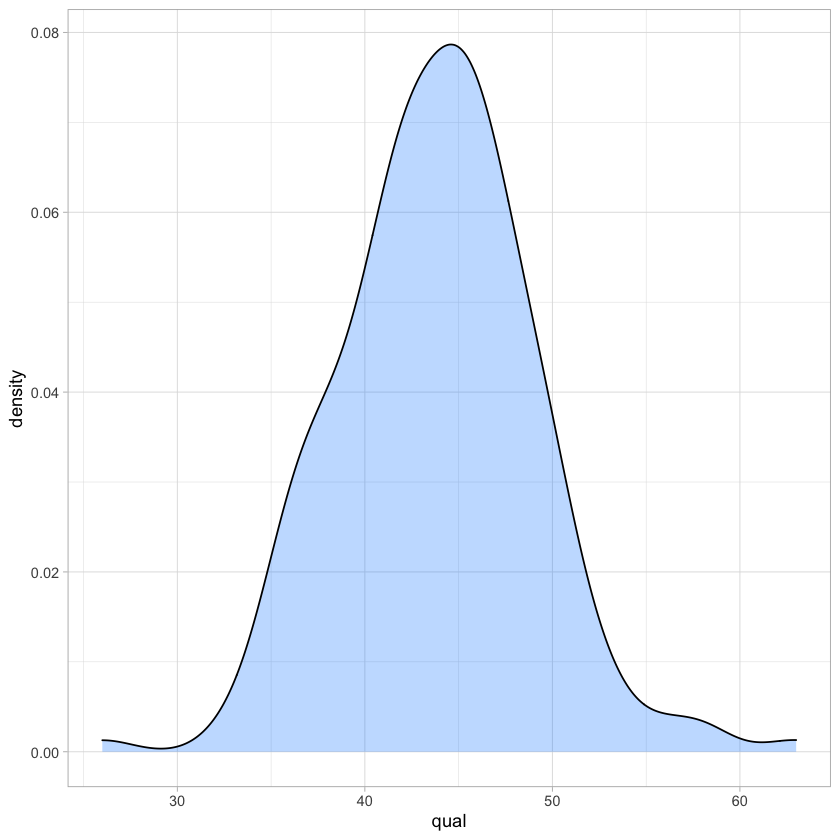

In [7]:
a <- ggplot(var_qual, aes(qual)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

### Variant mean depth

The number of reads that have mapped to this position.

For vcftools is the mean of the read depth across all individuals - it is for both alleles at a position and is not partitioned between the reference and the alternative

In [13]:
var_depth <- read_delim("./chr3_mwe.subset.ldepth.mean", delim = "\t",
           col_names = c("chr", "pos", "mean_depth", "var_depth"), skip = 1)
head(var_depth)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  mean_depth = col_double(),
  var_depth = col_double()
)



chr,pos,mean_depth,var_depth
<chr>,<dbl>,<dbl>,<dbl>
chr3,43332376,11.67810,13.70610
chr3,43340428,17.04030,5.32337
chr3,43348535,20.58050,30.12370
chr3,43372724,7.30615,10.34920
chr3,43549662,16.89340,12.24950
chr3,43576874,18.34340,51.38570


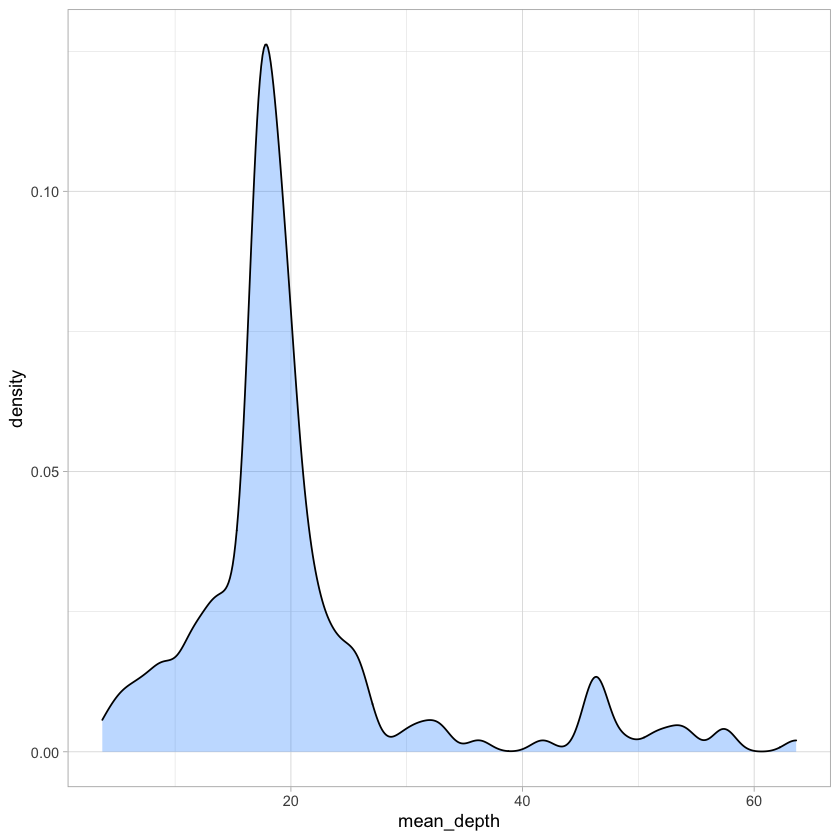

In [12]:
a <- ggplot(var_depth, aes(mean_depth)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

In [14]:
summary(var_depth$mean_depth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.716  16.785  18.157  20.429  21.122  63.626 

### Variant missingness

How many individuals lack a genotype at a call site

In [17]:
var_miss <- read_delim("./chr3_mwe.subset.lmiss", delim = "\t",
                       col_names = c("chr", "pos", "nchr", "nfiltered", "nmiss", "fmiss"), skip = 1)
head(var_miss)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  nchr = col_double(),
  nfiltered = col_double(),
  nmiss = col_double(),
  fmiss = col_double()
)



chr,pos,nchr,nfiltered,nmiss,fmiss
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr3,43332376,401286,0,5100,0.012709100
chr3,43340428,401286,0,0,0.000000000
chr3,43348535,401286,0,0,0.000000000
chr3,43372724,401286,0,1986,0.004949090
chr3,43549662,401286,0,182,0.000453542
chr3,43576874,401286,0,0,0.000000000


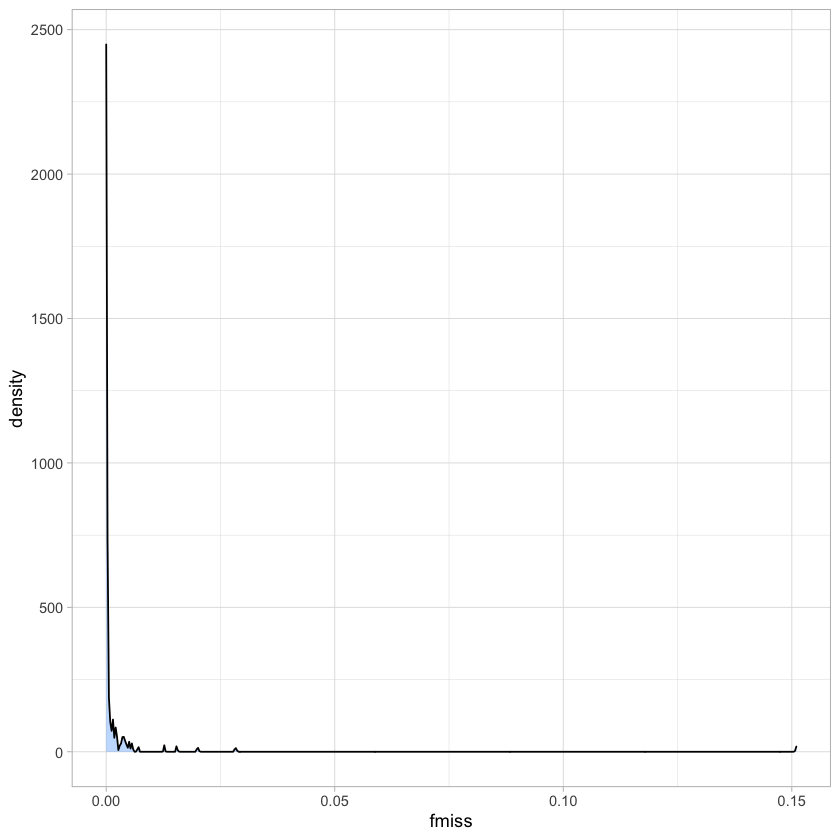

In [18]:
a <- ggplot(var_miss, aes(fmiss)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

In [19]:
summary(var_miss$fmiss)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 9.970e-06 1.692e-03 3.638e-04 1.510e-01 

### Minor allele frequency

In [21]:
var_freq <- read_delim("./chr3_mwe.subset.frq", delim = "\t",
                       col_names = c("chr", "pos", "nalleles", "nchr", "a1", "a2"), skip = 1)
head(var_freq)

Parsed with column specification:
cols(
  chr = col_character(),
  pos = col_double(),
  nalleles = col_double(),
  nchr = col_double(),
  a1 = col_double(),
  a2 = col_double()
)



chr,pos,nalleles,nchr,a1,a2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr3,43340428,2,401286,0.999873,1.27091e-04
chr3,43348535,2,401286,0.999995,4.98398e-06
chr3,43372724,2,399300,0.999992,7.51315e-06
chr3,43549662,2,401104,0.999998,2.49312e-06
chr3,43576874,2,401286,0.994662,5.33784e-03
chr3,43598764,2,399532,0.999995,5.00586e-06


In [24]:
# find minor allele frequency
var_freq$maf <- var_freq %>% select(a1, a2) %>% apply(1, function(z) min(z))
head(var_freq )

chr,pos,nalleles,nchr,a1,a2,maf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr3,43340428,2,401286,0.999873,1.27091e-04,1.27091e-04
chr3,43348535,2,401286,0.999995,4.98398e-06,4.98398e-06
chr3,43372724,2,399300,0.999992,7.51315e-06,7.51315e-06
chr3,43549662,2,401104,0.999998,2.49312e-06,2.49312e-06
chr3,43576874,2,401286,0.994662,5.33784e-03,5.33784e-03
chr3,43598764,2,399532,0.999995,5.00586e-06,5.00586e-06


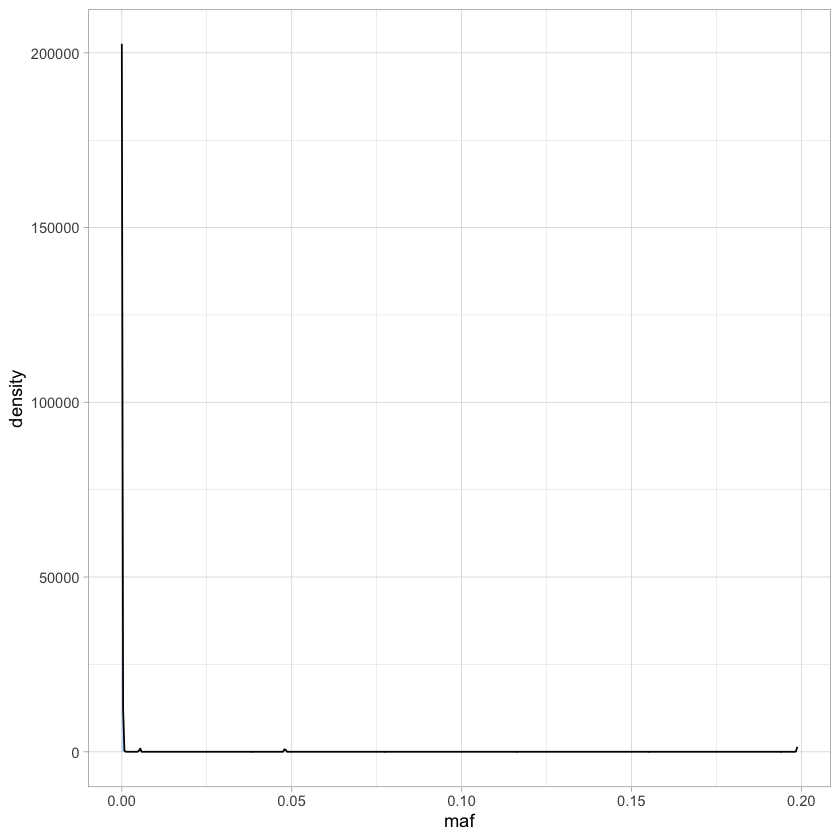

In [25]:
a <- ggplot(var_freq, aes(maf)) + geom_density(fill = "dodgerblue1", colour = "black", alpha = 0.3)
a + theme_light()

## Individual based statistics

### Mean depth per individual

In [27]:
ind_depth <- read_delim("./chr3_mwe.subset.idepth", delim = "\t",
                        col_names = c("ind", "nsites", "depth"), skip = 1)
head(ind_depth)                        

Parsed with column specification:
cols(
  ind = col_double(),
  nsites = col_double(),
  depth = col_double()
)



ind,nsites,depth
<dbl>,<dbl>,<dbl>
1434748,193,18.7772
5523981,193,22.7513
5023838,193,17.2850
4023729,193,20.1917
4442146,193,19.7358
5654789,193,19.8342


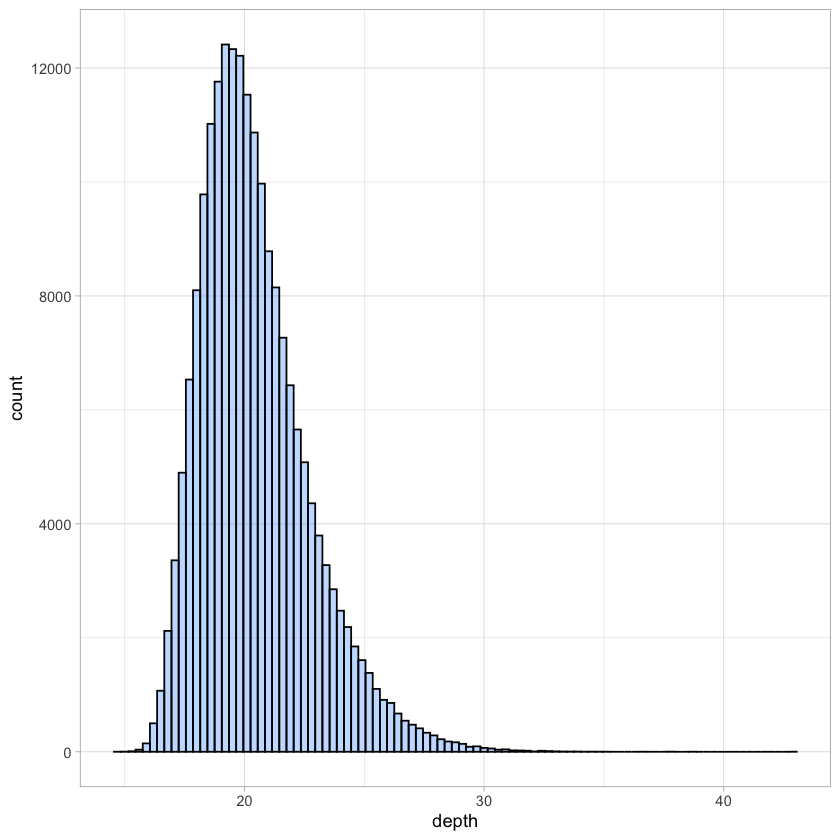

In [32]:
a <- ggplot(ind_depth, aes(depth)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3, binwidth=0.3)
a + theme_light()

### Proportion of missing data per individual

In [33]:
ind_miss  <- read_delim("./chr3_mwe.subset.imiss", delim = "\t",
                        col_names = c("ind", "ndata", "nfiltered", "nmiss", "fmiss"), skip = 1)

Parsed with column specification:
cols(
  ind = col_double(),
  ndata = col_double(),
  nfiltered = col_double(),
  nmiss = col_double(),
  fmiss = col_double()
)



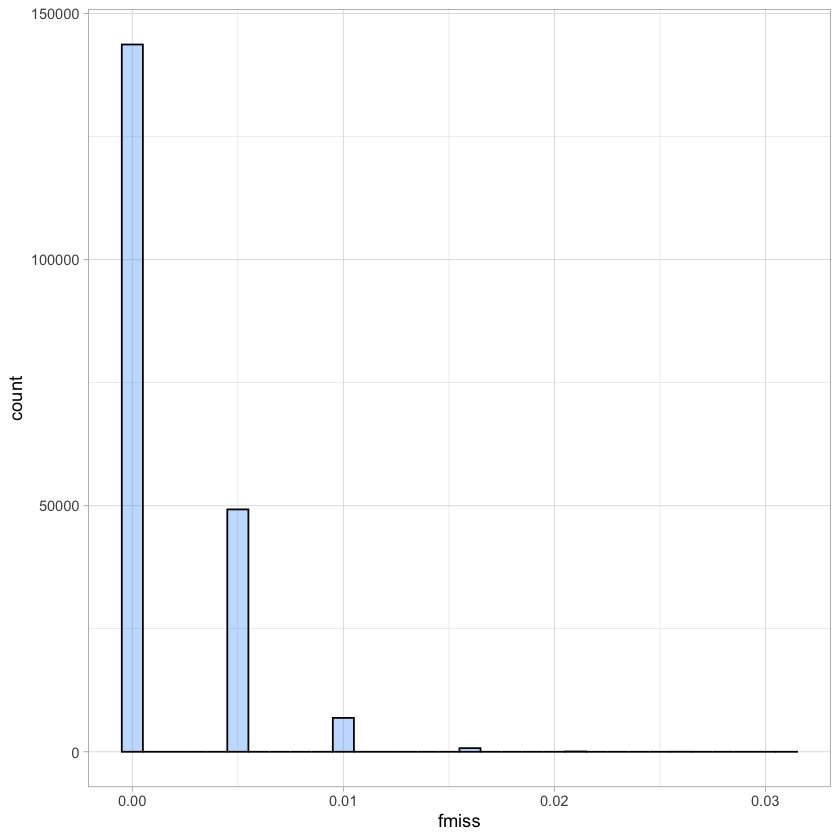

In [39]:
a <- ggplot(ind_miss, aes(fmiss)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3, binwidth=0.001)
a + theme_light()

### Heterozygosity and inbreeding coefficient per individual

High levels of allelic dropout/ allele with insufficient amplification (strongly negative F) or DNA contamination (highly positive F)

In [40]:
ind_het <- read_delim("./chr3_mwe.subset.het", delim = "\t",
           col_names = c("ind","ho", "he", "nsites", "f"), skip = 1)

Parsed with column specification:
cols(
  ind = col_double(),
  ho = col_double(),
  he = col_double(),
  nsites = col_double(),
  f = col_double()
)



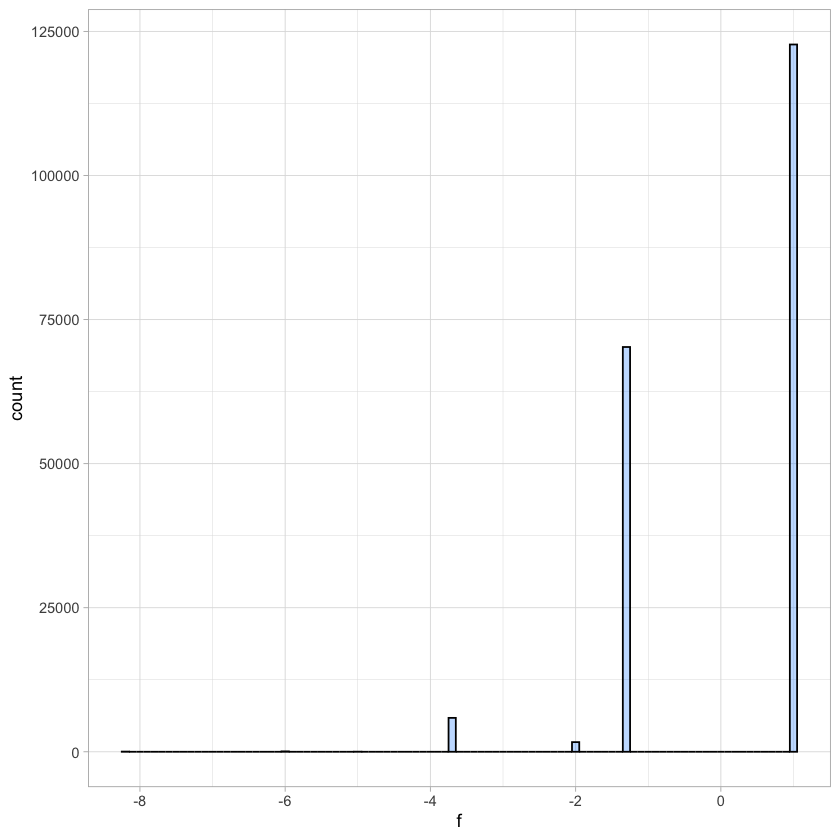

In [42]:
a <- ggplot(ind_het, aes(f)) + geom_histogram(fill = "dodgerblue1", colour = "black", alpha = 0.3, binwidth=0.1)
a + theme_light()

# Applying filters to the VCF

In [ ]:
VCF_IN=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset.vcf.gz
VCF_OUT=/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/chr3_mwe.subset_filtered.vcf.gz

## Set the filters

In [ ]:
MAF=0.1
MISS=0.9
QUAL=30
MIN_DEPTH=10
MAX_DEPTH=50

In [ ]:
# move to the vcf directory
cd vcf
# perform the filtering with vcftools
vcftools --gzvcf $VCF_IN \
--remove-indels --maf $MAF --max-missing $MISS --minQ $QUAL \
--min-meanDP $MIN_DEPTH --max-meanDP $MAX_DEPTH \
--minDP $MIN_DEPTH --maxDP $MAX_DEPTH --recode --stdout | gzip -c > \
$VCF_OUT


## Investigate the difference in samples for chr 2 and chr22 that are haing problems in the merge

In [1]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b58_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c2_b58_v1.samples

In [4]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b57_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c2_b57_v1.samples

In [ ]:
awk 'FNR==NR{a[$1];next}($1 in a){print}'  /home/dmc2245/ukb23156_c2_b58_v1.samples /home/dmc2245/ukb23156_c2_b57_v1.samples

In [5]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b59_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c2_b59_v1.samples

In [7]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b70_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c2_b70_v1.samples

In [6]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b0_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c2_b0_v1.samples

In [8]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c3_b0_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c3_b0_v1.samples

In [ ]:
cat /home/dmc2245/ukb23156_c2_b58_v1.samples | sort -n | head -n 20

In [9]:
comm <(sort /home/dmc2245/ukb23156_c2_b57_v1.samples) <(sort /home/dmc2245/ukb23156_c2_b58_v1.samples) -3

	-000016
	-000017
	-000018
1533484
2284688
3081695


In [2]:
bcftools query -l  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c20_b3_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c20_b3_v1.samples

In [1]:
bcftools query -l  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c20_b0_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c20_b0_v1.samples

### Different sample names in /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b63_v1.leftnorm.filtered.vcf.gz. Perhaps "bcftools merge" is what you are looking for?

In [3]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b63_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/ukb23156_c2_b63_v1.samples

In [10]:
diff -y  /home/dmc2245/ukb23156_c2_b58_v1.samples  /home/dmc2245/ukb23156_c2_b63_v1.samples > /home/dmc2245/different_chr2_b58_b63

: 1

### Different sample names in /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c20_b4_v1.leftnorm.filtered.vcf.gz

In [4]:
bcftools query -l /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c20_b4_v1.leftnorm.filtered.vcf.gz > /home/dmc2245/uukb23156_c20_b4_v1.samples

In [8]:
diff -y /home/dmc2245/ukb23156_c20_b3_v1.samples /home/dmc2245/uukb23156_c20_b4_v1.samples  > /home/dmc2245/different_chr20_b3_b4

: 1

In [17]:
for file in /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c20_b*_v1.leftnorm.filtered.vcf.gz; do 
 new_file="$(echo $file | sed s/.filtered.vcf.gz/.samples/)"
 bcftools query -l $file > $new_file
 echo "$new_file" >> /home/dmc2245/grep_results_chr20_new.txt
 egrep "1533484|2284688|3081695" $new_file >> /home/dmc2245/grep_results_chr20_new.txt ;
 done

: 1

In [18]:
for file in /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/plink_files/cache/ukb23156_c2_b*_v1.leftnorm.filtered.vcf.gz; do 
 new_file="$(echo $file | sed s/.filtered.vcf.gz/.samples/)"
 bcftools query -l $file > $new_file
 echo "$new_file" >> /home/dmc2245/grep_results_chr2_new.txt
 egrep "1533484|2284688|3081695" $new_file >> /home/dmc2245/grep_results_chr2_new.txt ;
 done

: 1

## Reheader bcftools to change samples name

In [16]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools
bcftools reheader -s samples_name.txt  -o chr3_mwe.subset_2samples.rename.vcf.gz chr3_mwe.subset_2samples.filter_3.vcf.gz

# Trying to understand the pattern of ti/tv ratio 

Problem: This ratio does not change after doing the filtering on the data. Also this is too low (~2.0) for exome data as it should be around 2.8 - 3.0

## Step 1: get only the regions captured by the targeted region

First I need to get these regions from one block using bcftools isec command

I will use chr22 block 0 for this test

In [9]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/

In [10]:
bcftools index ukb23156_c22_b0_v1.vcf.gz  -t 

In [13]:
bcftools view --regions-file /home/dmc2245/project/xgen_plus_spikein.GRCh38.bed /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/ukb23156_c22_b0_v1.vcf.gz -Oz -o chr22_b0_test-intersect.vcf.gz

In [14]:
bcftools index chr22_b0_test-intersect.vcf.gz  -t 

## Step 2: Look at VCF_QC_scripts.ipynb for details

- calculate stats before filtering
- apply filtering strategy (as default)
- caclculate stats after filtering

## Conclusions:

- No change in Ti/Tv ratio. 2.11 before and after filtering

## Step 3: Filter 150K samples that used the same capture array IDT xGen Exome Research Panel v1.0

Samples to exclude: 

/mnt/mfs/statgen/UKBiobank/data/exome_files/50K_exomes/ukb32285_exomespb_chr1_22.fam

In [ ]:
bcftools query -l chr22_b0_test-intersect.leftnorm.filtered.vcf.gz > samples.chr22_b0_test-intersect.leftnorm.filtered.txt

In [ ]:
comm -12 <( sort samples.chr22_b0_test-intersect.leftnorm.filtered.txt ) <( sort /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/50Ksamples_toremove_modified.txt )

Note: 11 samples are present in the 50K first exomed individuals and are not in the 200643 full dataset of exomed individuals

In [17]:
bcftools view -S ^/mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/50Ksamples_toremove_modified.txt chr22_b0_test-intersect.vcf.gz --force-samples -Oz -o chr22_b0_test-intersect_50Kremoved.vcf.gz

Warn: exclude called for sample that does not exist in header: "2155869"... skipping
Warn: exclude called for sample that does not exist in header: "3057281"... skipping
Warn: exclude called for sample that does not exist in header: "3832136"... skipping
Warn: exclude called for sample that does not exist in header: "3905696"... skipping
Warn: exclude called for sample that does not exist in header: "4151513"... skipping
Warn: exclude called for sample that does not exist in header: "4540229"... skipping
Warn: exclude called for sample that does not exist in header: "4709654"... skipping
Warn: exclude called for sample that does not exist in header: "5053018"... skipping
Warn: exclude called for sample that does not exist in header: "5136462"... skipping
Warn: exclude called for sample that does not exist in header: "5198198"... skipping
Warn: exclude called for sample that does not exist in header: "5683245"... skipping


## Step 4: Recalculate all of the stats in this scenario of sample filtering

- calculate stats before filtering
- apply filtering strategy (as default)
- calculate stats after filtering

## Step 5: Separate SNPs from indels and calculate  stats independently

Conclusion: indels.stats_bcftools gives a value of 0 as expected but the snp.stats_bcftools ti/tv is the same as in the unfiltered data

## Getting the full stats bcftools

In [30]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/

In [8]:
bcftools stats -v -s- ukb23156_c22_b0_v1.vcf.gz > ukb23156_c22_b0_v1.stats_verbose

In [ ]:
Result: ti/tv (1st alternative) ratio 2.35

## Interesting thoughts

To have an idea of what's happening and investigate a bit more the ti/tv ratio I did the following:

1. If I calculate ti/tv ratio in the raw vcf_file ukb23156_c22_b0_v1.vcf.gz I get these results

```
TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	10949	5356	2.04	10408	4426	2.35

SN    [2]id   [3]key  [4]value
SN      0       number of samples:      200643
SN      0       number of records:      15801
SN      0       number of no-ALTs:      0
SN      0       number of SNPs: 15116
SN      0       number of MNPs: 0
SN      0       number of indels:       1070
SN      0       number of others:       0
SN      0       number of multiallelic sites:   1668
SN      0       number of multiallelic SNP sites:       1264
```

2. Whereas if I calculate it from the raw data that was left-normalized (ukb23156_c22_b0_v1.leftnorm.vcf.gz) the second value where ts/tv is calculated using only the 1st ALT allele  changes and I get this

```
TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	11155	5488	2.03	11155	5488	2.03

SN    [2]id   [3]key  [4]value
SN      0       number of samples:      200643
SN      0       number of records:      17847
SN      0       number of no-ALTs:      0
SN      0       number of SNPs: 16643
SN      0       number of MNPs: 0
SN      0       number of indels:       1204
SN      0       number of others:       0
SN      0       number of multiallelic sites:   0
SN      0       number of multiallelic SNP sites:       0
```

3. Then if I calculate the stats in the filtered data I get the following. Almost the same as in the left-normalized data 

```
TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	11148	5479	2.03	11148	5479	2.03

SN    [2]id   [3]key  [4]value
SN      0       number of samples:      200643
SN      0       number of records:      17717
SN      0       number of no-ALTs:      0
SN      0       number of SNPs: 16627
SN      0       number of MNPs: 0
SN      0       number of indels:       1090
SN      0       number of others:       0
SN      0       number of multiallelic sites:   0
SN      0       number of multiallelic SNP sites:       0
```

Note: in case 3, I only considered a file with SNPs but as we can see after the filtering only 16 variants are being removed. This indicates that the stats are basically calculated with the exact same variants 


My thoughts, in the left-normalized data transitions/transversions are being counted more than once in the different multiallelic variants which definitely impacts the score

## Fill-in tags using bcftools to create better filtering strategy

In [1]:
bcftools +fill-tags -- -l

INFO/AC        Number:A  Type:Integer  ..  Allele count in genotypes
INFO/AC_Hom    Number:A  Type:Integer  ..  Allele counts in homozygous genotypes
INFO/AC_Het    Number:A  Type:Integer  ..  Allele counts in heterozygous genotypes
INFO/AC_Hemi   Number:A  Type:Integer  ..  Allele counts in hemizygous genotypes
INFO/AF        Number:A  Type:Float    ..  Allele frequency
INFO/AN        Number:1  Type:Integer  ..  Total number of alleles in called genotypes
INFO/ExcHet    Number:A  Type:Float    ..  Test excess heterozygosity; 1=good, 0=bad
INFO/END       Number:1  Type:Integer  ..  End position of the variant
INFO/F_MISSING Number:1  Type:Float    ..  Fraction of missing genotypes (all samples, experimental)
INFO/HWE       Number:A  Type:Float    ..  HWE test (PMID:15789306); 1=good, 0=bad
INFO/MAF       Number:A  Type:Float    ..  Minor Allele frequency
INFO/NS        Number:1  Type:Integer  ..  Number of samples with data
INFO/TYPE      Number:.  Type:String   ..  The record type (RE

: 255

In [ ]:
bcftools +fill-tags in.bcf -Ob -o out.bcf -- -t AN,AC

## Add aditional filters to the vcf

I'll try this in Chr 22 and evaluate how the ti/tv ratio changes

A set of QC metrics were applied to the variants included in Table1. Variants that passed the following criteria are included: individual and variant missingness <10%, Hardy Weinberg Equilibrium p-value>10^-15, minimum read coverage depth of 7 for SNPs and 10 for indels, at least one sample per site passed the allele balance threshold > 0.15 for SNPs and 0.20 for indels. Variants were annotated using SnpEff (Cingolani et al., 2012) based on Ensembl 85 gene model. Transcript aware annotations are derived using protein coding transcripts with defined start and stop coordinates

In [1]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/verbose_stats/cache

In [33]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) | (TYPE="INDEL"& FMT/DP<10 & FMT/GQ<20)' ukb23156_c22_b0_v1.leftnorm.vcf.gz| \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15) | 
                    (TYPE="indel" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.2)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.leftnorm.fullcode.vcf.gz

In [34]:
bcftools stats -v -s- ukb23156_c22_b0_v1.leftnorm.fullcode.vcf.gz > ukb23156_c22_b0_v1.leftnorm.fullcode.stats_bcftools

```
SN      0       number of samples:      200643
SN      0       number of records:      15842
SN      0       number of no-ALTs:      0
SN      0       number of SNPs: 14954
SN      0       number of MNPs: 0
SN      0       number of indels:       888
SN      0       number of others:       0
SN      0       number of multiallelic sites:   0
SN      0       number of multiallelic SNP sites:       0
```

In [36]:
bcftools stats -v -c snps -1 -s- ukb23156_c22_b0_v1.leftnorm.fullcode.vcf.gz > ukb23156_c22_b0_v1.leftnorm.collapse.stats_bcftools

In [40]:
bcftools query -f '%CHROM\t%POS\t[GT=%GT:AD=%AD:DP=%DP\t]\n' ukb23156_c22_b0_v1.leftnorm.fullcode.vcf.gz | grep -v "^#" | grep "DP=0"

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Use pVCF MWE to filter only SNPs

## Filter only SNPs

chr22 block 0

In [2]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) ' ukb23156_c22_b0_v1.leftnorm.vcf.gz| \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' |\
bcftools view -m2 -M2 -v snps -Oz -o ukb23156_c22_b0_v1.leftnorm.fullcode.onlybiallelic.vcf.gz

In [3]:
bcftools stats -v -s- ukb23156_c22_b0_v1.leftnorm.fullcode.onlybiallelic.vcf.gz > ukb23156_c22_b0_v1.leftnorm.fullcode.onlybiallelic.stats_bcftools

### Now get only biallelic and do not left normalize 

In [3]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/

In [5]:
bcftools view -m2 -M2 -v snps ukb23156_c22_b0_v1.vcf.gz -Oz -o ukb23156_c22_b0_v1.biallelic_only.vcf.gz

In [6]:
bcftools stats -v -s- ukb23156_c22_b0_v1.biallelic_only.vcf.gz > ukb23156_c22_b0_v1.biallelic_only.vchk

In [2]:
cat ukb23156_c22_b0_v1.biallelic_only.stats | grep "TSTV"

# TSTV, transitions/transversions:
# TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	9632	3835	2.51	9632	3835	2.51


In [7]:
plot-vcfstats -P -p /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/ ukb23156_c22_b0_v1.biallelic_only.vchk

Parsing bcftools stats output: ukb23156_c22_b0_v1.biallelic_only.vchk
Plotting graphs: python3 plot.py


In [2]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) ' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>1e-15' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.vcf.gz

In [8]:
bcftools stats -v -s- ukb23156_c22_b0_v1.onlybiallelic.filtered.vcf.gz > ukb23156_c22_b0_v1.onlybiallelic.filtered.stats

In [3]:
cat ukb23156_c22_b0_v1.onlybiallelic.filtered.stats | grep "TSTV"

# TSTV, transitions/transversions:
# TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	8635	3463	2.49	8635	3463	2.49


## Calculate the tstv using snpSift

In [ ]:
java -jar SnpSift.jar tstv  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/ukb23156_c22_b0_v1.biallelic_only.vcf.gz > ~/tstv.c22_b0.snpsift.txt

In [7]:
cat ~/tstv.c22_b0.snpsift.txt | awk -F, '{print $(NF)}' | head -n 15


TS/TV stats:
Total
10521339
3665336
2.870


Hom/Het stats:
Total
2688530852
7670090
3258292
2600047



In [ ]:
java -jar SnpSift.jar tstv  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/ukb23156_c22_b0_v1.onlybiallelic.filtered.vcf.gz > ~/tstv.c22_b0.filtered.snpsift.txt

In [8]:
cat ~/tstv.c22_b0.filtered.snpsift.txt | awk -F, '{print $(NF)}' | head -n 15


TS/TV stats:
Total
8428607
3000283
2.809


Hom/Het stats:
Total
2405116691
6100489
2664200
13497634



## The TSTV ratio is getting worse after filtering. Figure out why

In [10]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) ' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered_new.vcf.gz

In [ ]:
java -jar SnpSift.jar tstv  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/ukb23156_c22_b0_v1.onlybiallelic.filtered_new.vcf.gz > ~/tstv.c22_b0.filtered_new.snpsift.txt

In [12]:
cat ~/tstv.c22_b0.filtered_new.snpsift.txt | awk -F, '{print $(NF)}' | head -n 15


TS/TV stats:
Total
10240694
3574990
2.865


Hom/Het stats:
Total
2605268061
7618581
3098551
84669587



chr 21 block 10

In [171]:
bcftools view -m2 -M2 -v snps ukb23156_c21_b10_v1.vcf.gz  -Oz -o ukb23156_c21_b10_v1.biallelic_only.vcf.gz

In [172]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) ' ukb23156_c21_b10_v1.biallelic_only.vcf.gz | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING,'VD=sum(DP)' | \
bcftools filter -i 'F_MISSING<0.1 & HWE>1e-15' -Oz -o ukb23156_c21_b10_v1.biallelic_only.DP.vcf.gz

In [32]:
bcftools query -f'%CHROM:%POS:%REF:%ALT\t%AF\t%AQ\t%F_MISSING\t%HWE\t%VD\t%NS\t%MAF\n' ukb23156_c21_b10_v1.biallelic_only.DP.vcf.gz > ukb23156_c21_b10_v1.biallelic_only.DP.txt

In [37]:
bcftools query -l ukb23156_c21_b10_v1.biallelic_only.DP.vcf.gz | wc -l

200643


In [60]:
awk -F'\t' '{print $1, $2, $3, $4, $5, $6, $7, $8, $9=$6/200643}' ukb23156_c21_b10_v1.biallelic_only.DP.txt > ukb23156_c21_b10_v1.biallelic_only.stats.txt
echo -e "ID\tAF\tAQ\tF_MISSING\tHWE\tVD\tNS\tMAF\tAVG_VD" | cat - ukb23156_c21_b10_v1.biallelic_only.stats.txt > ukb23156_c21_b10_v1.biallelic_only.AVG_DP.txt

In [61]:
cat ukb23156_c21_b10_v1.biallelic_only.AVG_DP.txt | head

ID	AF	AQ	F_MISSING	HWE	VD	NS	MAF	AVG_VD
chr21:46356906:T:G 0.00285864 53 0.0576497 1 2448061 189076 0.00285864 12.2011
chr21:46356909:G:A 0.000228225 53 0.0391292 1 2582864 192792 0.000228225 12.8729
chr21:46356911:A:T 2.58087e-06 39 0.0344393 1 2618810 193733 2.58087e-06 13.0521
chr21:46356919:C:G 2.52834e-06 37 0.0143788 1 2884849 197758 2.52834e-06 14.378
chr21:46356923:A:G 2.50725e-06 46 0.00608544 1 3048372 199422 2.50725e-06 15.193
chr21:46356925:C:T 5.00979e-06 41 0.00515343 1 3089976 199609 5.00979e-06 15.4004
chr21:46356926:G:A 1.00136e-05 52 0.00456034 1 3104343 199728 1.00136e-05 15.472
chr21:46356930:G:A 0.0576546 56 0.00315486 0.410391 3249953 200010 0.0576546 16.1977
chr21:46356932:C:T 0.00174063 51 0.00213314 1 3320203 200215 0.00174063 16.5478
cat: write error: Broken pipe


In [64]:
cat ukb23156_c21_b10_v1.biallelic_only.AVG_DP.txt | wc -l

7115


In [63]:
awk '{ if ($9 < 20) { print } }' ukb23156_c21_b10_v1.biallelic_only.AVG_DP.txt | wc -l

4405


In [35]:
awk '$6=$6/200643' ukb23156_c21_b10_v1.biallelic_only.header.txt | head

chr21:46356906:T:G 0.00285864 53 0.0576497 1 12.2011 189076 0.00285864
chr21:46356909:G:A 0.000228225 53 0.0391292 1 12.8729 192792 0.000228225
chr21:46356911:A:T 2.58087e-06 39 0.0344393 1 13.0521 193733 2.58087e-06
chr21:46356919:C:G 2.52834e-06 37 0.0143788 1 14.378 197758 2.52834e-06
chr21:46356923:A:G 2.50725e-06 46 0.00608544 1 15.193 199422 2.50725e-06
chr21:46356925:C:T 5.00979e-06 41 0.00515343 1 15.4004 199609 5.00979e-06
chr21:46356926:G:A 1.00136e-05 52 0.00456034 1 15.472 199728 1.00136e-05
chr21:46356930:G:A 0.0576546 56 0.00315486 0.410391 16.1977 200010 0.0576546
chr21:46356932:C:T 0.00174063 51 0.00213314 1 16.5478 200215 0.00174063
chr21:46356938:C:T 3.74134e-05 47 0.000897116 1 17.0748 200463 3.74134e-05


In [180]:
bcftools query -i 'MAF > 0.4' -f'%CHROM\t%POS\t%REF\t%ALT\t%MAF\n' ukb23156_c21_b10_v1.biallelic_only.DP.vcf.gz | head

chr21	46554669	A	G	0.436863
chr21	46561000	G	T	0.490595


In [31]:
bcftools stats -v -s- -u MAF --af-tag MAF --af-bins 0.0001,0.001,0.01,0.1,0.5 -d 0,500,10 ukb23156_c21_b10_v1.biallelic_only.DP.vcf.gz > ukb23156_c21_b10_v1.biallelic_only.DP.stats.titvuser

## Add annotation from dbSNP

In [67]:
#File needs to be gziped and indexed first
tabix ukb23156_c21_b10_v1.biallelic_only.vcf.gz 
##INFO=<ID=RS

In [68]:
bcftools annotate -c +RS -a /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/dbSPN_hg38/00-All.vcf.gz \
    ukb23156_c21_b10_v1.biallelic_only.vcf.gz -Oz -o ukb23156_c21_b10_v1.biallelic_only.annot.vcf.gz

In [ ]:
bcftools query -i 'RS="."' -f '%CHROM:%POS:%REF:%ALT\t%RS\n' ukb23156_c21_b10_v1.biallelic_only.annot.vcf.gz | head -n 40

I need to change the notation of the chromosomes to chr1 on the annotation file or to 1 on the vcf file

In [13]:
bcftools annotate --rename-chrs renamechr.txt /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/dbSPN_hg38/00-All.vcf.gz -Oz -o /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/dbSPN_hg38/00-All.renamechrs.vcf.gz

In [ ]:
tabix /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/dbSPN_hg38/00-All.renamechrs.vcf.gz

In [4]:
#Create a header with the annotations I want to transfer
echo -e '##INFO=<ID=RS,Number=1,Type=Integer,Description="dbSNP ID (i.e. rs number)">' >> header.txt

In [14]:
#Using a smaller MWE
bcftools annotate  -a /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/dbSPN_hg38/00-All.vcf.gz  -h header.txt  chr3_mwe.subset_10samples.vcf.gz -Oz -o chr3_mwe.subset_10samples.annotdbSNP_RS.vcf.gz

In [11]:
bcftools query -f'%RS' chr3_mwe.subset_10samples.annotdbSNP_RS.vcf.gz

.................................................................................................................................................................................................

In [23]:
cd /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools

In [19]:
echo -e '##fileformat=VCFv4.3' > test.vcf
echo -e '##INFO=<ID=DP,Number=1,Type=Integer,Description="Read depth">' >> test.vcf
echo -e '##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">' >> test.vcf
echo -e '##contig=<ID=chr3,length=198295559>' >> test.vcf
echo -e '#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tsmpl1\tsmpl2' >> test.vcf
echo -e  'chr3\t43372724\tchr3_43372724_C_T\tC\tT\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43549662\tchr3_43549662_T_C\tT\tC\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43576874\tchr3_43576874_T_C\tT\tC\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43598764\tchr3_43598764_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43600513\tchr3_43600513_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43605742\tchr3_43605742_G_A\tG\tA\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43702181\tchr3_43702181_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43717573\tchr3_43717573_G_A\tG\tA\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43718397\tchr3_43718397_T_C\tT\tC\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t44243243\tchr3_44243243_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/1\t0/1' >> test.vcf
echo -e  'chr3\t43718561\tchr3_43718561_G_C\tG\tC\t.\t.\tDP=7\tGT\t0/1\t0/0' >> test.vcf
echo -e  'chr3\t44242909\tchr3_44242909_G_C\tG\tC\t.\t.\tDP=7\tGT\t0/1\t0/0' >> test.vcf
echo -e  'chr3\t43718561\tchr3_43718561_G_C\tG\tC\t.\t.\tDP=7\tGT\t0/0\t0/1' >> test.vcf
echo -e  'chr3\t44242993\tchr3_44242993_A_C\tA\tC\t.\t.\tDP=7\tGT\t0/0\t0/1' >> test.vcf


In [24]:
echo -e '##fileformat=VCFv4.3' > test1.vcf
echo -e '##INFO=<ID=DP,Number=1,Type=Integer,Description="Read depth">' >> test1.vcf
echo -e '##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">' >> test1.vcf
echo -e '##contig=<ID=chr3,length=198295559>' >> test1.vcf
echo -e '#CHROM\tPOS\tID\tREF\tALT\tQUAL\tFILTER\tINFO\tFORMAT\tsmpl1\tsmpl2' >> test1.vcf
echo -e  'chr3\t43372724\tchr3_43372724_C_T\tC\tT\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43549662\tchr3_43549662_T_C\tT\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43576874\tchr3_43576874_T_C\tT\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43598764\tchr3_43598764_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43600513\tchr3_43600513_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43605742\tchr3_43605742_G_A\tG\tA\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43702181\tchr3_43702181_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43717573\tchr3_43717573_G_A\tG\tA\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43718397\tchr3_43718397_T_C\tT\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t44243243\tchr3_44243243_A_G\tA\tG\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43718561\tchr3_43718561_G_C\tG\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t44242909\tchr3_44242909_G_C\tG\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t43718561\tchr3_43718561_G_C\tG\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf
echo -e  'chr3\t44242993\tchr3_44242993_A_C\tA\tC\t.\t.\tDP=7\tGT\t0/0\t0/0' >> test1.vcf

In [26]:
bgzip -c test.vcf > test.vcf.gz

In [27]:
bgzip -c test1.vcf > test1.vcf.gz

In [28]:
bcftools stats -v -s- test.vcf.gz > test.stats

In [29]:
bcftools stats -v -s- test1.vcf.gz > test1.stats

In [33]:
cat test.stats | grep -E "TSTV|PSC"

# TSTV, transitions/transversions:
# TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	10	4	2.50	10	4	2.50
# PSC, Per-sample counts. Note that the ref/het/hom counts include only SNPs, for indels see PSI. The rest include both SNPs and indels.
# PSC	[2]id	[3]sample	[4]nRefHom	[5]nNonRefHom	[6]nHets	[7]nTransitions	[8]nTransversions	[9]nIndels	[10]average depth	[11]nSingletons	[12]nHapRef	[13]nHapAlt	[14]nMissing
PSC	0	smpl1	2	0	12	10	2	0	0.0	2	0	0	0
PSC	0	smpl2	2	0	12	10	2	0	0.0	2	0	0	0


In [34]:
cat test1.stats | grep -E "TSTV|PSC"

# TSTV, transitions/transversions:
# TSTV	[2]id	[3]ts	[4]tv	[5]ts/tv	[6]ts (1st ALT)	[7]tv (1st ALT)	[8]ts/tv (1st ALT)
TSTV	0	10	4	2.50	10	4	2.50
# PSC, Per-sample counts. Note that the ref/het/hom counts include only SNPs, for indels see PSI. The rest include both SNPs and indels.
# PSC	[2]id	[3]sample	[4]nRefHom	[5]nNonRefHom	[6]nHets	[7]nTransitions	[8]nTransversions	[9]nIndels	[10]average depth	[11]nSingletons	[12]nHapRef	[13]nHapAlt	[14]nMissing
PSC	0	smpl1	14	0	0	0	0	0	0.0	0	0	0	0
PSC	0	smpl2	14	0	0	0	0	0	0.0	0	0	0	0


In [ ]:
java -jar SnpSift.jar tstv /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/test1.vcf.gz >  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/test1.stats.snpeff

In [ ]:
java -jar SnpSift.jar tstv /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/test.vcf.gz >  /mnt/mfs/statgen/UKBiobank/data/exome_files/project_VCF/testing_bcftools/test.stats.snpeff

## Calculate
-Variant level DP: double of average DP

## Use a vey strong AQ to filter and see if the ti/tv ratio improves

In [3]:
bcftools filter -i 'AQ>50' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) '  | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.AQ50.vcf.gz

In [4]:
bcftools stats -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ50.vcf.gz > ukb23156_c22_b0_v1.onlybiallelic.AQ50.stats

In [2]:
cat ukb23156_c22_b0_v1.onlybiallelic.AQ50.stats | head -n 40

# This file was produced by bcftools stats (1.11+htslib-1.11) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ50.vcf.gz
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	ukb23156_c22_b0_v1.onlybiallelic.AQ50.vcf.gz
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate alleles, all SNPs
# 
#

## Conclusion

The ti/tv ratio increased to 5.1 meaning it is extremely aggresive as it removed almost 90% of the variants

In [6]:
bcftools filter -i 'AQ>30' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) '  | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.AQ30.vcf.gz

In [7]:
bcftools stats -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ30.vcf.gz > ukb23156_c22_b0_v1.onlybiallelic.AQ30.stats

In [3]:
cat ukb23156_c22_b0_v1.onlybiallelic.AQ30.stats | head -n 40

# This file was produced by bcftools stats (1.11+htslib-1.11) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ30.vcf.gz
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	ukb23156_c22_b0_v1.onlybiallelic.AQ30.vcf.gz
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate alleles, all SNPs
# 
#

In [8]:
bcftools filter -i 'AQ>40' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) '  | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.AQ40.vcf.gz

In [9]:
bcftools stats -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ40.vcf.gz > ukb23156_c22_b0_v1.onlybiallelic.AQ40.stats

In [10]:
cat  ukb23156_c22_b0_v1.onlybiallelic.AQ40.stats | head -n 40

# This file was produced by bcftools stats (1.11+htslib-1.11) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ40.vcf.gz
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	ukb23156_c22_b0_v1.onlybiallelic.AQ40.vcf.gz
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate alleles, all SNPs
# 
#

In [11]:
bcftools filter -i 'AQ>35' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) '  | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.AQ35.vcf.gz

In [12]:
bcftools stats -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ35.vcf.gz > ukb23156_c22_b0_v1.onlybiallelic.AQ35.stats

In [13]:
cat  ukb23156_c22_b0_v1.onlybiallelic.AQ35.stats | head -n 40

# This file was produced by bcftools stats (1.11+htslib-1.11) and can be plotted using plot-vcfstats.
# The command line was:	bcftools stats  -v -s- ukb23156_c22_b0_v1.onlybiallelic.AQ35.vcf.gz
#
# Definition of sets:
# ID	[2]id	[3]tab-separated file names
ID	0	ukb23156_c22_b0_v1.onlybiallelic.AQ35.vcf.gz
# SN, Summary numbers:
#   number of records   .. number of data rows in the VCF
#   number of no-ALTs   .. reference-only sites, ALT is either "." or identical to REF
#   number of SNPs      .. number of rows with a SNP
#   number of MNPs      .. number of rows with a MNP, such as CC>TT
#   number of indels    .. number of rows with an indel
#   number of others    .. number of rows with other type, for example a symbolic allele or
#                          a complex substitution, such as ACT>TCGA
#   number of multiallelic sites     .. number of rows with multiple alternate alleles
#   number of multiallelic SNP sites .. number of rows with multiple alternate alleles, all SNPs
# 
#

In [152]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) ' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING,'VD=sum(DP)' | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.DP.vcf.gz

In [153]:
bcftools query -l ukb23156_c22_b0_v1.onlybiallelic.DP.vcf.gz | wc -l

200643


In [165]:
bcftools query -f'%CHROM:%POS:%REF:%ALT\t%INFO\n' ukb23156_c22_b0_v1.onlybiallelic.DP.vcf.gz | head

chr22:15528096:G:A	AF=2.21103e-05;AQ=22;AC=8;AN=361822;F_MISSING=0.0983438;VD=2528966;NS=180911;MAF=2.21103e-05;AC_Het=8;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.999923
chr22:15528109:T:G	AF=0.000117467;AQ=26;AC=44;AN=374574;F_MISSING=0.066566;VD=2721852;NS=187287;MAF=0.000117467;AC_Het=44;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.997477
chr22:15528133:A:G	AF=1.27289e-05;AQ=37;AC=5;AN=392808;F_MISSING=0.0211271;VD=3077094;NS=196404;MAF=1.27289e-05;AC_Het=5;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.999975
chr22:15528155:G:A	AF=0.000138979;AQ=35;AC=55;AN=395742;F_MISSING=0.0138156;VD=3197386;NS=197871;MAF=0.000138979;AC_Het=55;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.996254
chr22:15528165:C:A	AF=0.000184536;AQ=28;AC=73;AN=395586;F_MISSING=0.0142043;VD=3296838;NS=197793;MAF=0.000184536;AC_Het=73;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.993378
chr22:15528166:C:T	AF=7.55215e-06;AQ=26;AC=3;AN=397238;F_MISSING=0.0100876;VD=3300582;NS=198619;MAF=7.55215e-06;AC_Het=3;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.999992
chr22:15528177:C:T	AF=0

In [4]:
bcftools query -f'%CHROM:%POS:%REF:%ALT\t%AF\t%AQ\t%F_MISSING\t%VD\t%NS\t%MAF\n' ukb23156_c22_b0_v1.onlybiallelic.DP.vcf.gz > ukb23156_c22_b0_v1.onlybiallelic.DP.txt

In [159]:
zcat ukb23156_c22_b0_v1.onlybiallelic.DP.vcf.gz | grep -v "^#" | awk -F '\t' '{print $8}' | awk -F ';' '{print $6,$7}' | awk '{gsub(/[^0-9. ]/,"")}1' | head

2528966 180911
2721852 187287
3077094 196404
3197386 197871
3296838 197793
3300582 198619
3359783 198611
3690242 199151
3755171 199431
3824453 200320
grep: write error: Broken pipe

gzip: stdout: Broken pipe


In [ ]:
bcftools +fill-tags ukb23156_c22_b0_v1.biallelic_only.vcf.gz -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.DP.vcf.gz -- -t 'VD=sum(DP)'

In [ ]:
zcat ukb23156_c22_b0_v1.biallelic_only.vcf.gz | grep "DP"

In [ ]:
zcat ukb23156_c22_b0_v1.onlybiallelic.filtered.DP.vcf.gz | grep "DP"

In [33]:
#not supported by bcftools only sum is supported at this point in time
bcftools +fill-tags ukb23156_c22_b0_v1.biallelic_only.vcf.gz -Oz -o ukb23156_c22_b0_v1.onlybiallelic.AVGDP.vcf.gz -- -t 'VD=AVG(DP)'

In [47]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\tAC=%AC\tAN=%AN\t%INFO\n' ukb23156_c22_b0_v1.onlybiallelic.AVGDP.vcf.gz  | grep -v "^#" | head

chr22	15528096	G	A	AC=.	AN=.	AF=5e-06;AQ=22;VD=2528966
chr22	15528109	T	G	AC=.	AN=.	AF=7e-06;AQ=26;VD=2721852
chr22	15528133	A	G	AC=.	AN=.	AF=5e-06;AQ=37;VD=3077094
chr22	15528155	G	A	AC=.	AN=.	AF=6e-05;AQ=35;VD=3197386
chr22	15528165	C	A	AC=.	AN=.	AF=5e-06;AQ=28;VD=3296838
chr22	15528166	C	T	AC=.	AN=.	AF=5e-06;AQ=26;VD=3300582
chr22	15528177	C	T	AC=.	AN=.	AF=4.2e-05;AQ=35;VD=3359783
chr22	15528179	G	T	AC=.	AN=.	AF=0.000264;AQ=32;VD=4056239
chr22	15528182	C	T	AC=.	AN=.	AF=7e-06;AQ=32;VD=3690242
chr22	15528188	C	T	AC=.	AN=.	AF=1.5e-05;AQ=27;VD=3755171
grep: write error: Broken pipe
[query_vcf] Error: cannot write to standard output


In [67]:
bcftools query -i 'AVG(FMT/DP) > 50' -f'%CHROM\t%POS\t%REF\t%ALT\t[%DP ]\n' ukb23156_c22_b0_v1.onlybiallelic.AVGDP.vcf.gz  | grep -v "^#" | head

chr22	15690112	C	T	20 26 0 25 27 46 40 116 168 117 44 2 161 21 49 21 38 25 19 24 202 31 184 19 38 35 0 114 172 42 21 30 35 31 20 0 41 52 36 17 48 53 38 48 31 18 26 44 40 48 52 43 173 151 33 25 23 182 162 131 52 44 124 18 51 22 30 154 29 45 16 0 49 85 50 30 17 21 24 31 32 48 2 0 148 26 157 34 0 16 38 47 36 40 19 51 150 7 44 1 19 0 41 98 2 20 45 63 44 22 0 2 155 41 16 95 47 16 16 34 150 2 26 16 62 94 27 23 178 26 25 45 29 16 16 147 2 207 31 137 152 98 26 26 26 7 35 34 41 41 52 0 40 49 54 17 36 4 42 21 26 51 0 0 56 51 48 29 157 16 29 35 105 0 43 0 23 46 4 22 19 0 181 32 42 44 0 31 32 2 38 27 140 24 42 166 36 39 31 2 56 163 110 137 46 16 18 43 48 39 30 48 187 33 0 38 16 114 30 81 44 32 16 35 141 54 20 42 24 129 28 126 22 33 33 27 17 30 31 56 154 46 28 2 128 2 16 20 149 41 59 2 32 39 27 141 16 152 187 30 151 168 29 23 46 23 147 16 41 52 0 2 24 53 104 48 141 16 2 21 32 0 43 42 2 34 29 29 145 2 112 36 31 55 52 27 143 21 0 46 21 21 0 22 185 21 34 0 180 0 2 16 183 54 36 39 157 24 27 4 188 36 35

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [52]:
bcftools --version

bcftools 1.12
Using htslib 1.12
Copyright (C) 2021 Genome Research Ltd.
License Expat: The MIT/Expat license
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.


## Use toy example to understand sum behavior 

Select only bi-allelic snps

In [ ]:
bcftools view -m2 -M2 -v snps ukb23156_c22_b0_v1.vcf.gz -Oz -o ukb23156_c22_b0_v1.biallelic_only.vcf.gz

Filter SNPs base on GQ, DP, allelic balance, F_Missing and HWE. Add some tags

In [ ]:
bcftools filter  -S . -e '(TYPE="SNP" & FMT/DP<7 & FMT/GQ<20) ' ukb23156_c22_b0_v1.biallelic_only.vcf.gz | \
bcftools view -c1 | \
bcftools filter -i 'GT="hom" | (TYPE="snp" & GT="het" & (FMT/AD[*:1])/(FORMAT/AD[*:0] + FMT/AD[*:1]) >= 0.15)' | \
bcftools +fill-tags -- -t all,F_MISSING | \
bcftools filter -i 'F_MISSING<0.1 & HWE>0.000000000000001' -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.vcf.gz

Select some samples to create a MWE 

In [72]:
bcftools query -l ukb23156_c22_b0_v1.onlybiallelic.filtered.vcf.gz | head

1434748
5523981
5023838
4023729
4442146
5654789
4515669
1129683
5327043
4744741


In [73]:
bcftools view -s 1434748,5523981,5023838,4023729,4442146  ukb23156_c22_b0_v1.onlybiallelic.filtered.vcf.gz -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples.vcf.gz

In [75]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t[%DP ]\n' ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples.vcf.gz | head

chr22	15528096	G	A	12 19 4 11 12 
chr22	15528109	T	G	14 21 3 11 13 
chr22	15528133	A	G	19 22 4 14 16 
chr22	15528155	G	A	19 22 7 14 16 
chr22	15528165	C	A	19 22 8 16 16 
chr22	15528166	C	T	19 22 8 16 16 
chr22	15528177	C	T	19 22 8 17 16 
chr22	15528182	C	T	23 16 10 17 18 
chr22	15528188	C	T	23 16 12 17 18 
chr22	15528194	G	A	23 16 12 17 18 
[query_vcf] Error: cannot write to standard output


In [79]:
bcftools index ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples.vcf.gz -t -f

In [80]:
bcftools view -r chr22:15528096-15528194 ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples.vcf.gz -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples_10vars.vcf.gz

In [81]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t[%DP ]\n' ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples_10vars.vcf.gz

chr22	15528096	G	A	12 19 4 11 12 
chr22	15528109	T	G	14 21 3 11 13 
chr22	15528133	A	G	19 22 4 14 16 
chr22	15528155	G	A	19 22 7 14 16 
chr22	15528165	C	A	19 22 8 16 16 
chr22	15528166	C	T	19 22 8 16 16 
chr22	15528177	C	T	19 22 8 17 16 
chr22	15528182	C	T	23 16 10 17 18 
chr22	15528188	C	T	23 16 12 17 18 
chr22	15528194	G	A	23 16 12 17 18 


In [82]:
bcftools +fill-tags ukb23156_c22_b0_v1.onlybiallelic.filtered.5samples_10vars.vcf.gz -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.vcf.gz -- -t 'VD=sum(DP)'

In [89]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t[DP=%DP GT=%GT ]\n' ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.vcf.gz

chr22	15528096	G	A	DP=12 GT=0/0 DP=19 GT=0/0 DP=4 GT=./. DP=11 GT=0/0 DP=12 GT=0/0 
chr22	15528109	T	G	DP=14 GT=0/0 DP=21 GT=0/0 DP=3 GT=./. DP=11 GT=0/0 DP=13 GT=0/0 
chr22	15528133	A	G	DP=19 GT=0/0 DP=22 GT=0/0 DP=4 GT=./. DP=14 GT=0/0 DP=16 GT=0/0 
chr22	15528155	G	A	DP=19 GT=0/0 DP=22 GT=0/0 DP=7 GT=0/0 DP=14 GT=0/0 DP=16 GT=0/0 
chr22	15528165	C	A	DP=19 GT=0/0 DP=22 GT=0/0 DP=8 GT=0/0 DP=16 GT=0/0 DP=16 GT=0/0 
chr22	15528166	C	T	DP=19 GT=0/0 DP=22 GT=0/0 DP=8 GT=0/0 DP=16 GT=0/0 DP=16 GT=0/0 
chr22	15528177	C	T	DP=19 GT=0/0 DP=22 GT=0/0 DP=8 GT=0/0 DP=17 GT=0/0 DP=16 GT=0/0 
chr22	15528182	C	T	DP=23 GT=0/0 DP=16 GT=0/0 DP=10 GT=0/0 DP=17 GT=0/0 DP=18 GT=0/0 
chr22	15528188	C	T	DP=23 GT=0/0 DP=16 GT=0/0 DP=12 GT=0/0 DP=17 GT=0/0 DP=18 GT=0/0 
chr22	15528194	G	A	DP=23 GT=0/0 DP=16 GT=0/0 DP=12 GT=0/0 DP=17 GT=0/0 DP=18 GT=0/0 


In [ ]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t%INFO\t[%DP ]\n' ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.vcf.gz

In [148]:
bcftools +fill-tags ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.vcf.gz -Oz -o ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.new.vcf.gz -- -t NS,'VD=sum(DP)'

In [149]:
bcftools query -f'%CHROM\t%POS\t%REF\t%ALT\t%INFO\t[%DP ]\n' ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.new.vcf.gz

chr22	15528096	G	A	AF=2.21103e-05;AQ=22;AC=0;AN=8;F_MISSING=0.0983438;NS=4;MAF=2.21103e-05;AC_Het=8;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.999923;VD=58	12 19 4 11 12 
chr22	15528109	T	G	AF=0.000117467;AQ=26;AC=0;AN=8;F_MISSING=0.066566;NS=4;MAF=0.000117467;AC_Het=44;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.997477;VD=62	14 21 3 11 13 
chr22	15528133	A	G	AF=1.27289e-05;AQ=37;AC=0;AN=8;F_MISSING=0.0211271;NS=4;MAF=1.27289e-05;AC_Het=5;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.999975;VD=75	19 22 4 14 16 
chr22	15528155	G	A	AF=0.000138979;AQ=35;AC=0;AN=10;F_MISSING=0.0138156;NS=5;MAF=0.000138979;AC_Het=55;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.996254;VD=78	19 22 7 14 16 
chr22	15528165	C	A	AF=0.000184536;AQ=28;AC=0;AN=10;F_MISSING=0.0142043;NS=5;MAF=0.000184536;AC_Het=73;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.993378;VD=81	19 22 8 16 16 
chr22	15528166	C	T	AF=7.55215e-06;AQ=26;AC=0;AN=10;F_MISSING=0.0100876;NS=5;MAF=7.55215e-06;AC_Het=3;AC_Hom=0;AC_Hemi=0;HWE=1;ExcHet=0.999992;VD=81	19 22 8 16 16 
chr22	15528177	C	T	AF=0

In [138]:
zcat ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.new.vcf.gz | grep -v "^#" | awk -F '\t' '{print $8}' | awk -F ';' '{print $6,$13}' | awk '{gsub(/[^0-9. ]/,"")}1'

4 58
4 62
4 75
5 78
5 81
5 81
5 82
5 84
5 86
5 86


In [150]:
bcftools query -l ukb23156_c22_b0_v1.onlybiallelic.filtered.5s10v.sumDP.new.vcf.gz |wc -l

5
